In [2]:
import pandas as pd
import pickle
import seaborn as sns
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import matplotlib.pyplot as plt
from collections import Counter

import numpy as np
import spacy
from string import punctuation
from faker import Faker

In [3]:
df = pd.read_pickle('C:/Saravana/Data/Raw/export-cleansed-4851f054c66579780503d70880731802.pkl.bz2')

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
display(df.head())

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,NUTZFALL,NUTZFALL_RAUM,MUSIKLEITER_NAME,KAPELLE_NAME,TARIF_NR,TARIF_BEZ,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,VERANST_NAME,VERANST_STRASSE,VERANST_PLZ,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938765,24643,2016,ABRE U INKA 2016,NaN,5027961220,4.0,NONRekla,2014-02-09,LISBERG,TURNHALLE SV RW LISBERG,20140209.0,TURNHALLE SV RW LISBERG,NaN,NaN,892,U-K (MUSIKER),18293163,140.0,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,NaN,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,6.0,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.0,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194
9938851,24643,2016,ABRE U INKA 2016,NaN,5044481411,3.0,NONRekla,2014-03-15,MUENCHEN,WERNER-VON-SIEMENS-SCHULZENTRUM,20140315.0,WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483465,72.5,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN WERNER-VON-SIEMENS-SCHULZENTRUM,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938852,24643,2016,ABRE U INKA 2016,NaN,5044481427,2.0,NONRekla,2014-03-14,MUENCHEN,PFARRHEIM UND KIRCHE,20140314.0,PFARRHEIM UND KIRCHE,NaN,NaN,974,U-K (MUSIKER) MINDESTVERGUETUNG,18483423,34.8,NaN,NaN,2000179545,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V,HOCHAECKERSTR. 123,81737,MUENCHEN,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,MUENCHEN PFARRHEIM UND KIRCHE,NaN,BLASORCHESTER ST. MICHAEL MUENCHEN-PERLACH E.V...
9938853,24643,2016,ABRE U INKA 2016,NaN,5044481469,2.0,NONRekla,2014-02-09,GRAFENRHEINFELD,KULTURHALLE GRAFENRHEINFELD,20140209.0,KULTURHALLE GRAFENRHEINFELD,NaN,NaN,892,U-K (MUSIKER),18184927,34.8,NaN,NaN,1023588500,MUSIKVEREIN WERNECK E.V,VON-FECHENBACH-STR. 27,97440,WERNECK,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,GRAFENRHEINFELD KULTURHALLE GRAFENRHEINFELD,NaN,MUSIKVEREIN WERNECK E.V 97440


In [ ]:
pd.set_option('display.max_rows', None)

In [6]:
df.VERANST_SEGMENT.unique()

array([ 4.,  6.,  3.,  2.,  5.,  7.,  8., 10.,  9., 11., 12.])

In [7]:
df.VG_RAUM.unique()

['TURNHALLE SV RW LISBERG', 'WERNER-VON-SIEMENS-SCHULZENTRUM', 'PFARRHEIM UND KIRCHE', 'KULTURHALLE GRAFENRHEINFELD', 'VEREINSHEIM TSV FRIESENRIED', ..., 'LEERSTAND 28.09.20', 'QUARTIERZENTRUM B26', 'GOETHE-INSTITUTE AUSLAND', 'COCKTAILBAR SUESS WAR GESTERN', 'TRAUMPALAST BIBERACH']
Length: 129572
Categories (129571, object): ['" DE SMUGGLER " CELTIC PUB', '" DORNSPACHHAUS " HISTOR. WIRTSHAUS', '" DORNSPACHHAUS " HISTORISCHES WIRTSHAUS', '" FIZZ " FESTE FEIERN', ..., 'ZWOENITZ', 'ZWOGGEL', 'ZWOTA', 'ZYCKO']

In [8]:
len(df.index)

3296137

In [9]:
# Convert all the event segments > 3 to a event segment - 4
df.loc[df['VERANST_SEGMENT'] > 3, 'VERANST_SEGMENT'] = 4

In [10]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) & segment 4(>100 euros)
allclaims_df = df.query('VERANST_SEGMENT <= 4')
len(allclaims_df.index)

3296137

### Unique values

In [11]:
print('Unique bands: ',len(df.BAND.unique()))
print('Unique locations: ',len(df.VG_ORT.unique()))
print('Unique venues: ',len(df.VG_RAUM.unique()))
print('Unique Promoters: ',len(df.PROMOTER.unique()))
print('Unique tariffs: ',len(df.TARIF_BEZ.unique()))

Unique bands:  329380
Unique locations:  12090
Unique venues:  129572
Unique Promoters:  243003
Unique tariffs:  91


### Visualize missing data

In [12]:
missing_data_in_df = pd.DataFrame(
    {
        "Attributes": ["imp_id", "gj", "import", "mufo_referenz_n", "barcode_nr", "veranst_segment", "rekla_jn", "vg_datum_von", "vg_ort",
                      "vg_raum", "nutzfall", "nutzfall_raum", "musikleiter_name", "kapelle_name", "tarif_nr", "tarif_bez", 
                      "nutzfall_nr", "vg_inkasso", "inkasso_netto", "inkasso_brutto", "veranst_geschaeftszeichen", "veranst_name",
                      "veranst_strasse", "veranst_plz", "veranst_ort", "nutzliznehm_geschaeftszeichen", "nutzliznehm_name", "nutzliznehm_vorname",
                      "nutzliznehm_strasse", "nutzliznehm_plz", "nutzliznehm_ort", "location", "band", "promoter"], 
        "missing (in million(s))": [0, 0, 0, 3205313, 0, 0, 0, 0, 222, 155, 0, 151, 2104917, 1477728, 0, 0, 0, 0, 2933130, 2933130, 0, 121, 20393, 
                    1225, 697, 0, 1038426, 2941456, 1052479, 1038887, 1038426, 151, 1453088, 121],
    }
)

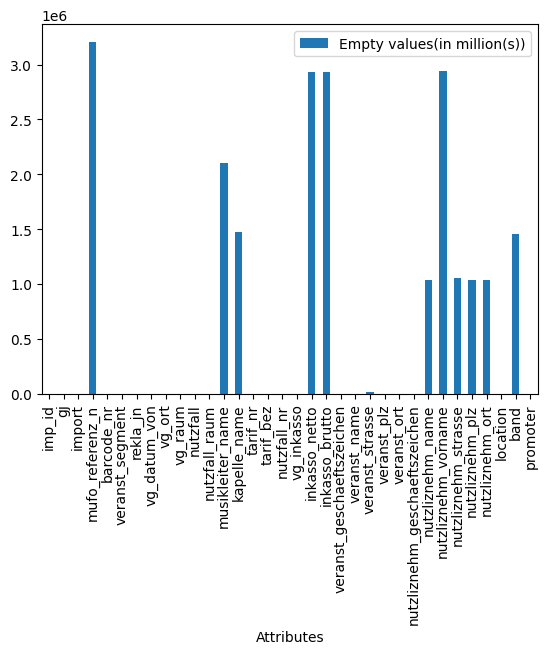

In [13]:
_, ax = plt.subplots()
missing_data_in_df.plot.bar(x="Attributes", ax= ax)
ax.legend(["Empty values(in million(s))"])

## Class distribution plot  

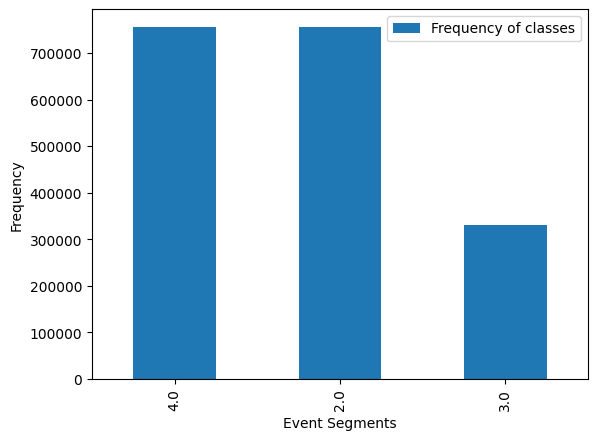

In [20]:
fig, ax = plt.subplots()

# fads = allclaims_df.copy()
# fads.rename(columns = {'test':'TEST'}, inplace = True)

allclaims_df.VERANST_SEGMENT.value_counts().plot(ax=ax, kind='bar', xlabel='Event Segments', ylabel='Frequency')
# ax.legend(["2.0 - Class 0(0-50€)", "3.0 - Class 1(50€-100€)", "4.0 - Class 2(>100€)"])
# ax.legend(["3.0 - Class 1(50€-100€)"])
# ax.legend(["4.0 - Class 2(>100€)"])
ax.legend(['Frequency of classes'])
plt.show()

In [ ]:
# Filter segment 2(0-50 euros) & segment 3(50-100 euros) 
# lowerclaim_df = df.query('VERANST_SEGMENT <= 3')
# len(lowerclaim_df.index)

## Remove missing 

Remove missing values from VG_ORT

In [15]:
allclaims_df = allclaims_df[allclaims_df['VG_ORT'].isnull()==False]
len(allclaims_df.index)

3295915

Remove missing values from BAND

In [16]:
allclaims_df = allclaims_df[allclaims_df['BAND'].isnull()==False]
len(allclaims_df.index)

1842904

Remove missing values from PROMOTER

In [17]:
allclaims_df = allclaims_df[allclaims_df['PROMOTER'].isnull()==False]
len(allclaims_df.index)

1842855

In [18]:
print('Unique locations: ',len(allclaims_df.VG_ORT.unique()))

Unique locations:  11323


In [19]:
display(allclaims_df.columns)
# Count NaN values for each column in the dataframe
display(allclaims_df.isna().sum())

Index(['IMP_ID', 'GJ', 'IMPORT', 'MUFO_REFERENZ_N', 'BARCODE_NR',
       'VERANST_SEGMENT', 'REKLA_JN', 'VG_DATUM_VON', 'VG_ORT', 'VG_RAUM',
       'NUTZFALL', 'NUTZFALL_RAUM', 'MUSIKLEITER_NAME', 'KAPELLE_NAME',
       'TARIF_NR', 'TARIF_BEZ', 'NUTZFALL_NR', 'VG_INKASSO', 'INKASSO_NETTO',
       'INKASSO_BRUTTO', 'VERANST_GESCHAEFTSZEICHEN', 'VERANST_NAME',
       'VERANST_STRASSE', 'VERANST_PLZ', 'VERANST_ORT',
       'NUTZLIZNEHM_GESCHAEFTSZEICHEN', 'NUTZLIZNEHM_NAME',
       'NUTZLIZNEHM_VORNAME', 'NUTZLIZNEHM_STRASSE', 'NUTZLIZNEHM_PLZ',
       'NUTZLIZNEHM_ORT', 'LOCATION', 'BAND', 'PROMOTER'],
      dtype='object')

IMP_ID                                 0
GJ                                     0
IMPORT                                 0
MUFO_REFERENZ_N                  1781918
BARCODE_NR                             0
VERANST_SEGMENT                        0
REKLA_JN                               0
VG_DATUM_VON                           0
VG_ORT                                 0
VG_RAUM                                4
NUTZFALL                               0
NUTZFALL_RAUM                          0
MUSIKLEITER_NAME                  651791
KAPELLE_NAME                       24634
TARIF_NR                               0
TARIF_BEZ                              0
NUTZFALL_NR                            0
VG_INKASSO                             0
INKASSO_NETTO                    1599542
INKASSO_BRUTTO                   1599542
VERANST_GESCHAEFTSZEICHEN              0
VERANST_NAME                           0
VERANST_STRASSE                    11435
VERANST_PLZ                          807
VERANST_ORT     

In [ ]:
IMP_ID                                 
GJ                               GeschäftsJahr      
IMPORT                           Distribution where the data came from      
MUFO_REFERENZ_N                  
BARCODE_NR                             
VERANST_SEGMENT                  Event segment
REKLA_JN                         Reclamation 

VG_DATUM_VON                     Event Date
VG_ORT                           Event place
VG_RAUM                          Event room

NUTZFALL                         Usage of event  
NUTZFALL_RAUM                    Usage Room or Music hall where the music is used

MUSIKLEITER_NAME                 Music Leader name
KAPELLE_NAME                     Chapel name

TARIF_NR                         Tariff Number
TARIF_BEZ                        Tariff Bez
NUTZFALL_NR                      Usecase Number

VG_INKASSO                       Event collection
INKASSO_NETTO                    Net-Collection
INKASSO_BRUTTO                   Gross-Collection
VERANST_GESCHAEFTSZEICHEN        Event business sign or mark 
VERANST_NAME                     Event name
VERANST_STRASSE                  Event street
VERANST_PLZ                      Event post code
VERANST_ORT                      Event place

# Nutzungs Lizenznehmer - someone who has got the license(Usage licence) for the music works
NUTZLIZNEHM_GESCHAEFTSZEICHEN    
NUTZLIZNEHM_NAME                 name of person who aquired usage license
NUTZLIZNEHM_VORNAME              surname of person who aquired usage license
NUTZLIZNEHM_STRASSE              street of person who aquired usage license
NUTZLIZNEHM_PLZ                  postcode of person who aquired usage license
NUTZLIZNEHM_ORT                  place of person who aquired usage license

LOCATION                         location - VG_ORT + VG_RAUM
BAND                             band - KAPELLE_NAME and empty rows of kapelle name is filled with MUSIKLEITER_NAME
PROMOTER                         promoter - VERANST_NAME + VERANST_PLZ

VG_RAUM = 'IM FREIEN'(In Outside) or Name of the City


In [ ]:
print(allclaims_df['VG_INKASSO'].max())
print(allclaims_df['VG_INKASSO'].min())

Univariate Plotting - Distribution of the event collection in Euros

In [ ]:
# kde - Kernel Density
sns.displot(allclaims_df['VG_INKASSO'], kde=False)
plt.show()

## Scrapping German Cities and States from Wikipedia

In [21]:
import requests
from bs4 import BeautifulSoup as bs

In [22]:
# Load the webpage
r = requests.get("https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Germany")

# Convert the webpage content to soup object
webpage = bs(r.content)

Remove special characters and convert to uppercase

In [23]:
def remove_special_char_convert_to_uppercase(text):
    each = text.replace('ß','SS')
    each = each.upper()
    each = each.replace('Ä', 'AE')
    each = each.replace('Ö', 'OE')
    each = each.replace('Ü', 'UE')
    return each

In [24]:
c_names = ["City", "State"]
l = []
for i in range(0,25):
    table = webpage.select("table")[i]
    list = table.select("li")
    for c in list:
        each = remove_special_char_convert_to_uppercase(c.get_text(','))
        texts = each.split(',')
        city = texts[0]
        if city == 'MUNICH': city = 'MUENCHEN'
        if city == 'COLOGNE': city = 'KOELN' 
        if city == 'NUREMBERG': city = 'NUERNBERG'
        if city == 'HANOVER': city = 'HANNOVER'
         
        state = texts[1].replace('(','').replace(')','')
        l.append([city , state])
print(l[0])

['AACH', ' BADEN-WUERTTEMBERG']


In [25]:
print(len(l))

2055


In [26]:
cities_states_de_df = pd.DataFrame(l, columns=c_names)
cities_states_de_df.head()

,City,State
0,AACH,BADEN-WUERTTEMBERG
1,AACHEN,NORTH RHINE-WESTPHALIA
2,AALEN,BADEN-WUERTTEMBERG
3,ABENBERG,BAVARIA
4,ABENSBERG,BAVARIA


In [27]:
print(len(cities_states_de_df))

2055


In [28]:
cities_states_de_df[cities_states_de_df['City']=='KOELN']

,City,State
347,KOELN,NORTH RHINE-WESTPHALIA


VG_ORT

In [29]:
# Some VG_ORT values contains of format-1:<cityname, specific region name>
# Replace all the places containing of format-1 with cityname
allPlaces=allclaims_df['VG_ORT'].tolist()
place_indicies_with_comma = [i for i in range(len(allPlaces)) if ',' in allPlaces[i]]

iter_index = 0
for each_index in allclaims_df.index[allclaims_df['VG_ORT'].str.contains(',') == True].tolist():
    cityname = allclaims_df.at[each_index, 'VG_ORT'].split(r",")[0]
    allPlaces[place_indicies_with_comma[iter_index]] = cityname
    iter_index += 1

allclaims_df['VG_ORT'] = pd.Categorical(allPlaces, ordered = False)

len(allclaims_df[allclaims_df['VG_ORT'].str.contains(',') == True])

0

Matching the state for each city or town (location) in VG_ORT

In [30]:
allclaims_df['vg_state'] = ''

In [31]:
for each in cities_states_de_df.itertuples() :
    city = each.City
    state = each.State
    allclaims_df.loc[allclaims_df['VG_ORT'] == city, 'vg_state'] = state.strip()


Load the Municipality and states in Germany that are scraped from WikiData

In [32]:
wiki_municipality_df = pd.read_csv('C:/Saravana/Projects/Intellizenz/intellizenz-model-training/data/submunicipality_municipality_district_state_germany_v3.csv')
wiki_municipality_df[['stateLabel','municipalityLabel','submunicipalityLabel']]

,stateLabel,municipalityLabel,submunicipalityLabel
0,Baden-Württemberg,Bad Urach,Bad Urach
1,Baden-Württemberg,Geislingen an der Steige,Weiler ob Helfenstein
2,Baden-Württemberg,Schramberg,Sulgen
3,Baden-Württemberg,Triberg im Schwarzwald,Triberg im Schwarzwald
4,Baden-Württemberg,Baiersbronn,Klosterreichenbach
...,...,...,...
35902,Thuringia,Frohnsdorf,NaN
35903,Bavaria,Osterberg,NaN
35904,Thuringia,Windischleuba,NaN
35905,Bavaria,Schirnding,NaN


In [36]:
for each in wiki_municipality_df.itertuples() :
    municipality = remove_special_char_convert_to_uppercase(each.municipalityLabel)
    state = remove_special_char_convert_to_uppercase(each.stateLabel)
    submunicipality = remove_special_char_convert_to_uppercase(str(each.submunicipalityLabel))
    allclaims_df.loc[allclaims_df['VG_ORT'] == municipality, 'vg_state'] = state.strip()
    allclaims_df.loc[allclaims_df['VG_ORT'] == submunicipality, 'vg_state'] = state.strip()

In [37]:
# Checking the empty values in vg_state column
dafsdf = allclaims_df[allclaims_df['vg_state'] == '']
print(len(dafsdf))
print('Unique : {}'.format(len(dafsdf.VG_ORT.unique())))

0
Unique : 0


## Remove empty values from vg_state

In [38]:
allclaims_df = allclaims_df[allclaims_df['vg_state'] != '']
len(allclaims_df.index)

1742197

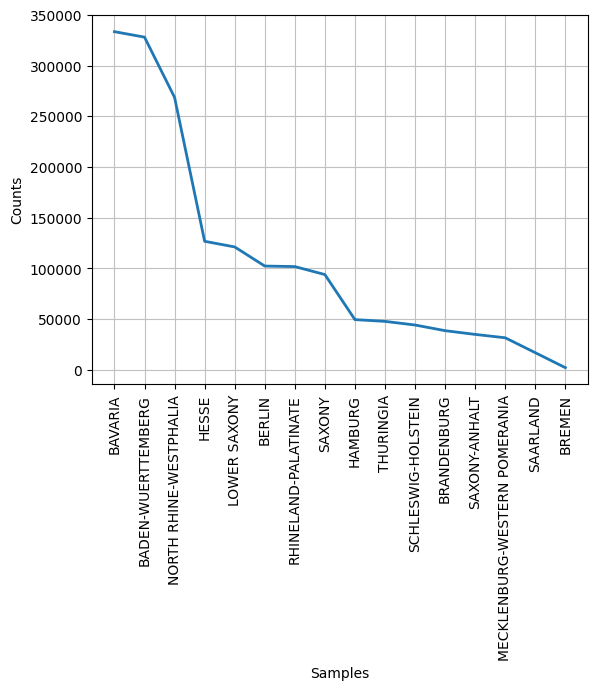

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [39]:
flat_list_vg_state = [item for item in allclaims_df['vg_state']]
fdist_vg_state = FreqDist(flat_list_vg_state)
fdist_vg_state.plot(cumulative=False)

## Visualize the percentage of events in different states


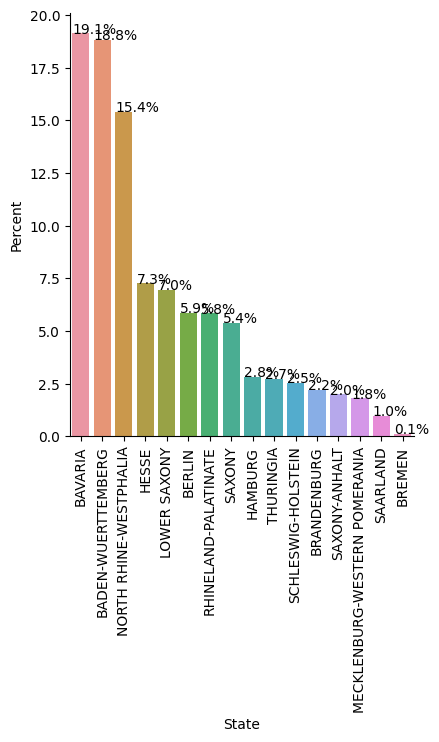

In [132]:
state_categories_df = allclaims_df['vg_state'].value_counts(normalize=True)
state_categories_df = state_categories_df.mul(100).rename('Percent').reset_index()
state_categories_df.rename(columns = {'index':'State'}, inplace = True)

g = sns.catplot(x='State', y='Percent', kind='bar', data=state_categories_df)
g.ax.tick_params(axis='x', rotation=90)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [40]:
print(fdist_vg_state.values())
for each in fdist_vg_state:
    print(each)

dict_values([333483, 47799, 328081, 101840, 38633, 102360, 121209, 44211, 49530, 126771, 16918, 268676, 34946, 93972, 31622, 2146])
BAVARIA
BADEN-WUERTTEMBERG
NORTH RHINE-WESTPHALIA
HESSE
LOWER SAXONY
BERLIN
RHINELAND-PALATINATE
SAXONY
HAMBURG
THURINGIA
SCHLESWIG-HOLSTEIN
BRANDENBURG
SAXONY-ANHALT
MECKLENBURG-WESTERN POMERANIA
SAARLAND
BREMEN


In [ ]:
seg2_and_seg3_claims_df = allclaims_df.query('VERANST_SEGMENT == 4')

In [ ]:
ax = sns.barplot(x="vg_state", y="VG_INKASSO",  data=seg2_and_seg3_claims_df)
#sns.violinplot("vg_state", "VG_INKASSO", data=seg2_and_seg3_claims_df)

plt.ylim(2000, 20000)
plt.xticks(rotation=90)
plt.show()

In [51]:
afds = allclaims_df[allclaims_df['vg_state']=='BREMEN']
print(afds['VG_INKASSO'].max())
print(afds['VG_INKASSO'].min())

fdsfs = afds[afds['VG_INKASSO']==16026.28]
fdsfs

16026.28
8.3


,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,...,BAND,PROMOTER,vg_state,VG_RAUM_clean,VG_RAUM_WO_STOPWORDS,VG_RAUM_KEYWORDS,VG_DATUM_YEAR,VG_DATUM_MONTH,VG_DATUM_DAY_OF_WEEK,VG_DATUM_SEASON
ID,,,,,,,,,,,,,,,,,,,,,
10130967,24643,2016,ABRE U INKA 2016,NaN,6703772318,4,NONRekla,2016-09-02,BREMERHAVEN,BREMERHAVEN,...,UNHEILLIG,STADTHALLE BREMERHAVEN VERANSTALTUNGS- UND MES...,BREMEN,BREMERHAVEN,bremerhaven,[bremerhaven],2016,9,4,4
10776863,26943,2017,ABRE U INKA 2017,NaN,5211131992,4,NONRekla,2016-09-02,BREMERHAVEN,BREMERHAVEN,...,BE ONE,STADTHALLE BREMERHAVEN VERANSTALTUNGS- UND MES...,BREMEN,BREMERHAVEN,bremerhaven,[bremerhaven],2016,9,4,4


## Retreive the states, where event takes place - Featurize vg_state

In [31]:
all_states = [i[0] for i in fdist_vg_state.items()] 
df_featurize_vg_state = pd.DataFrame(allclaims_df['vg_state'])

for term in all_states :
    df_featurize_vg_state['state_'+term.lower()]=df_featurize_vg_state['vg_state'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_state.head(10))

,vg_state,state_BAVARIA,state_THURINGIA,state_BADEN-WUERTTEMBERG,state_RHINELAND-PALATINATE,state_BRANDENBURG,state_BERLIN,state_LOWER SAXONY,state_SCHLESWIG-HOLSTEIN,state_HAMBURG,state_HESSE,state_SAARLAND,state_NORTH RHINE-WESTPHALIA,state_SAXONY-ANHALT,state_SAXONY,state_MECKLENBURG-WESTERN POMERANIA,state_BREMEN
ID,,,,,,,,,,,,,,,,,
9938766,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,THURINGIA,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Retreive the most common 30 VG_ORT, where event occurs - Featurize VG_ORT

In [ ]:
flat_list_vg_ort = [item for item in allclaims_df['VG_ORT']]
fdist_vg_ort = FreqDist(flat_list_vg_ort)
most_common_terms_vg_ort = [i[0] for i in fdist_vg_ort.most_common(30)] 
df_featurize_vg_ort = pd.DataFrame(allclaims_df['VG_ORT'])

for term in most_common_terms_vg_ort :
    df_featurize_vg_ort['location_'+term]=df_featurize_vg_ort['VG_ORT'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_ort.head(10))

In [ ]:
fdist_vg_ort.plot(30,cumulative=False)

## Featurize TARIF_BEZ


In [54]:
print('Unique Tarif: ', len(allclaims_df['TARIF_BEZ'].unique()))

Unique Tarif:  87


In [55]:
flat_list_tarif_desc = [item for item in allclaims_df['TARIF_BEZ']]
fdist_tarif_desc = FreqDist(flat_list_tarif_desc)

In [56]:
most_common_terms_tarif = [i[0] for i in fdist_tarif_desc.most_common(30)] 
df_featurize_tarif = pd.DataFrame(allclaims_df['TARIF_BEZ'])

for term in most_common_terms_tarif :
    df_featurize_tarif['tarif_'+term.lower()]=df_featurize_tarif['TARIF_BEZ'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_tarif.head(10))

,TARIF_BEZ,tarif_u-v ii. 1 (+ii 2),tarif_u-k (musiker),tarif_u-k (musiker) mindestverguetung,tarif_u-st i. (musiker),tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil,tarif_u-st i (musiker) nl,tarif_u-v iii. 1,tarif_u-v iii. 2,tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten,tarif_variete i (musiker),tarif_u-v vi. b,tarif_e (musiker),tarif_p-k i. (u-musik),tarif_u-k ii. (musiker) bis 50 min,tarif_u-k ii. (musiker) bis 20 min,tarif_e-p,tarif_u-k ii. (musiker) bis 25 min,tarif_u-k ii. (musiker) bis 15 min,tarif_u-k ii. (musiker) bis 30 min,tarif_u-k ii. (musiker) bis 10 min,tarif_u-st (musiker),tarif_chorverband konzert u-musik,tarif_vk i 3 zirkusunternehmen (musiker),tarif_u-k ii. (musiker) bis 5 min,tarif_u-k ii. (musiker) bis 35 min,tarif_u-k ii. (musiker) bis 40 min,tarif_p-k i. (e-musik),tarif_u-k ii (musiker) mindestverguetung,tarif_u-k ii. (musiker) bis 45 min,tarif_u-v vi. b mindestverguetung
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,U-V II. 1 (+II 2),1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


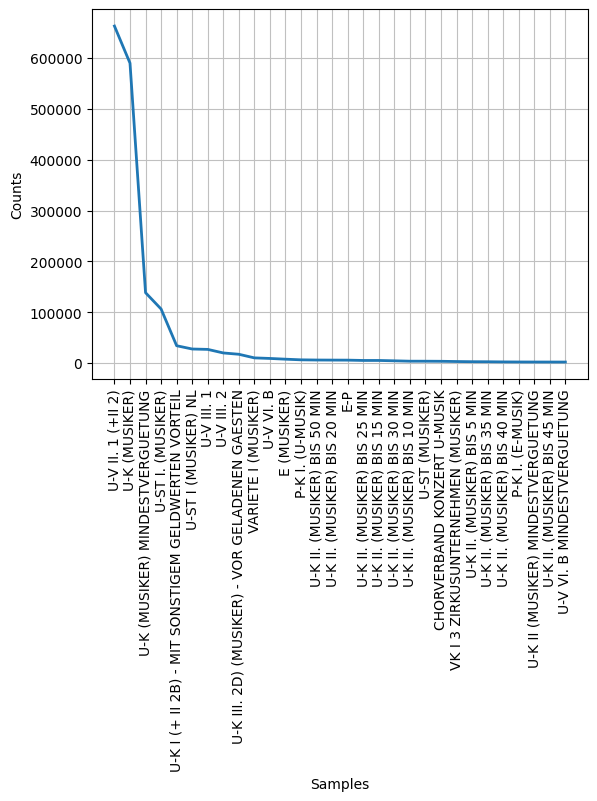

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [57]:
fdist_tarif_desc.plot(30,cumulative=False)

### Group the frequent tariffs and rest of the tarifs to 'Other'

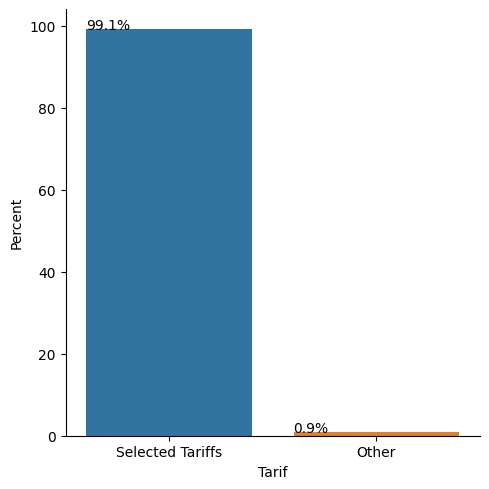

In [113]:
df_featurize_tarif['grouped_tarif']=df_featurize_tarif['TARIF_BEZ'].apply(lambda x: 'Selected Tariffs' if x in most_common_terms_tarif else 'Other')

tarif_categories_df = df_featurize_tarif['grouped_tarif'].value_counts(normalize=True)
tarif_categories_df = tarif_categories_df.mul(100).rename('Percent').reset_index()
tarif_categories_df.rename(columns = {'index':'Tarif'}, inplace = True)

g = sns.catplot(x='Tarif', y='Percent', kind='bar', data=tarif_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

## Anonymize Band

In [64]:
faker = Faker(['de_DE'])

Faker.seed(43)

dict_bands = {band: faker.unique.company() for band in allclaims_df['BAND'].unique()}
allclaims_df['anonymized_band'] = allclaims_df['BAND'].map(dict_bands)

### Check the distribution of actual band & anonymized band

In [65]:
print('Actual unique bands: ', len(allclaims_df['BAND'].unique()))
print('Anonymized unique bands: ', len(allclaims_df['anonymized_band'].unique()))

Actual unique bands:  317007
Anonymized unique bands:  317007
Actual unique promoters:  170016
Anonymized unique promoters:  170016


### Visualize anonymized Band

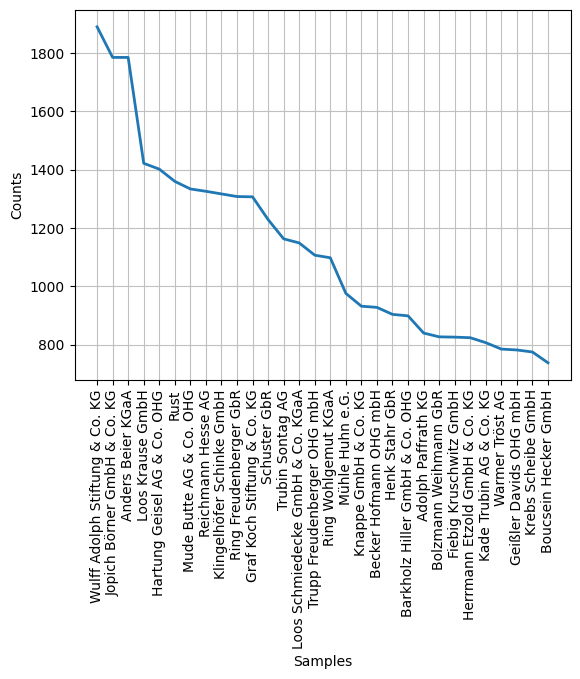

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [277]:
flat_list_fake_bands = [item for item in allclaims_df['anonymized_band']]
fdist_fake_band = FreqDist(flat_list_fake_bands)
fdist_fake_band.plot(30,cumulative=False)

## Featurize Promoter

### Clean Promoter values; promoter_clean

In [114]:
df_featurize_promoter = pd.DataFrame(allclaims_df['PROMOTER'])
df_featurize_promoter["promoter_clean"] = allclaims_df['VERANST_NAME']

In [115]:
display(allclaims_df.isna().sum())

IMP_ID                                 0
GJ                                     0
IMPORT                                 0
MUFO_REFERENZ_N                  1683816
BARCODE_NR                             0
VERANST_SEGMENT                        0
REKLA_JN                               0
VG_DATUM_VON                           0
VG_ORT                                 0
VG_RAUM                                4
NUTZFALL                               0
NUTZFALL_RAUM                          0
MUSIKLEITER_NAME                  617820
KAPELLE_NAME                       23596
TARIF_NR                               0
TARIF_BEZ                              0
NUTZFALL_NR                            0
VG_INKASSO                             0
INKASSO_NETTO                    1509555
INKASSO_BRUTTO                   1509555
VERANST_GESCHAEFTSZEICHEN              0
VERANST_NAME                           0
VERANST_STRASSE                    10995
VERANST_PLZ                          787
VERANST_ORT     

### Remove repeating company types from 'Promoter'. 
#### Get the frequencies of unique promoter entries until total of 1742197 counts(len of dataframe) is reached. Set remaining promoter entries to 'Other'

In [220]:
def remove_repeating_org_names(column,threshold=0.75,substrings=[],return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  # Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    category_name = i

    for substr in substrings:
      category_name = category_name.replace('K. D. OE. R','K.D.OE.R')
      if category_name.count(substr) == 2:
          category_name = category_name.replace(substr,'X',1) # replace 1st occurance of the string with X
          category_name = category_name.replace(substr,'').strip() # replace 2st occurance of the string with empty
          category_name = category_name.replace('X', substr) # replace X with substring value

    #Append the category name to the list
    categories_list.append(category_name)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break

  # Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  
  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

In [222]:
org_strings = ['GMBH & CO. KG', 'E.V', 'GMBH', 'GBR', 'K.D.OE.R', 'OHG']
tran_new_column,new_cat_list=remove_repeating_org_names(df_featurize_promoter['promoter_clean'],threshold=1.00,substrings=org_strings,return_categories_list=True)

KeyboardInterrupt: 

In [241]:
print(len(allclaims_df['promoter_transform'].unique()))
print(len(allclaims_df['BAND'].unique()))

164542
317007


In [ ]:
tran_new_column.describe

### Transform the Promoter column to remove repetitive company name

In [117]:
# Remove the repeating organisation(company types) substring from Organizer/Promoter
def transform_promoter(x, substrings):
    str_value = x
    str_value = str_value.replace('K. D. OE. R','K.D.OE.R')

    # y = lambda substrings, str_value: (subs if(str_value.count(subs)==2) else ''  for subs in substrings)
    # result_sub_str = y(substrings, str_value)

    for subs in substrings:
        if str_value.count(subs) == 2:
            str_value = str_value.replace(subs,'X',1) # replace 1st occurance of the string with X
            str_value = str_value.replace(subs,'').strip() # replace 2st occurance of the string with empty
            str_value = str_value.replace('X', subs) # replace X with substring value
            return str_value
        else:
            return str_value

In [118]:
orgs = ['GMBH & CO. KG', 'E.V', 'GMBH', 'GBR', 'K.D.OE.R', 'OHG']

df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_clean'], substrings=[orgs[0]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[1]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[2]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[3]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[4]]), axis=1)
df_featurize_promoter['promoter_transform'] = df_featurize_promoter.apply(lambda x: transform_promoter(x['promoter_transform'], substrings=[orgs[5]]), axis=1)

In [121]:
allclaims_df['promoter_transform'] = df_featurize_promoter['promoter_transform']

## Anonymize Promoter

In [273]:
dict_promoters = {promoter: faker.unique.company() for promoter in allclaims_df['promoter_transform'].unique()}
allclaims_df['anonymized_promoter'] = allclaims_df['promoter_transform'].map(dict_promoters)

### Check the distribution of promoter and Anonymized promoter

In [274]:
print('Actual unique promoters: ', len(allclaims_df['promoter_transform'].unique()))
print('Anonymized unique promoters: ', len(allclaims_df['anonymized_promoter'].unique()))

Actual unique promoters:  164542
Anonymized unique promoters:  164542


### Visualize Anonymized Promoter

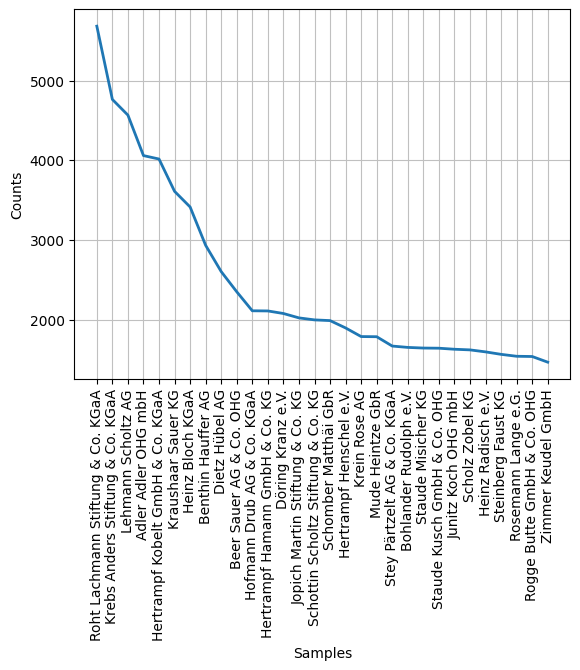

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [275]:
flat_list_fake_promoters = [item for item in allclaims_df['anonymized_promoter']]
fdist_fake_promoter = FreqDist(flat_list_fake_promoters)
fdist_fake_promoter.plot(30,cumulative=False)

### Visualize Actual Promoter

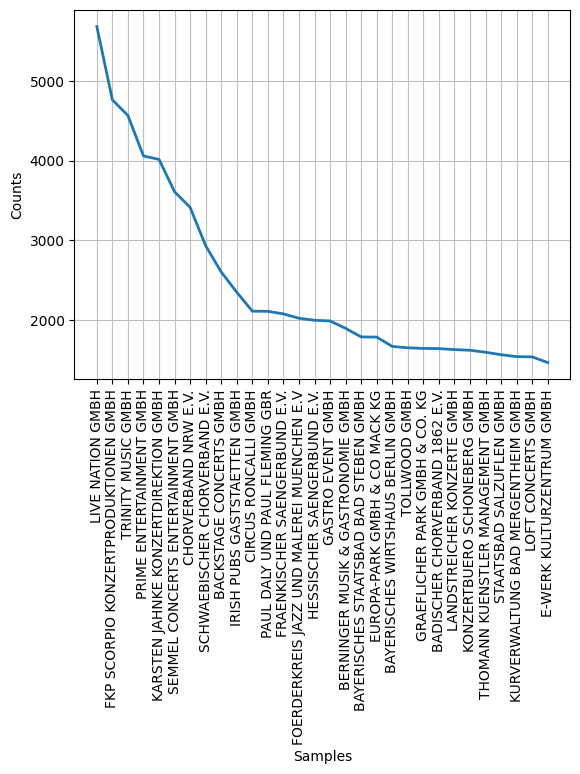

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [122]:
flat_list_actual_promoters = [item for item in df_featurize_promoter['promoter_transform']]
fdist_actual_promoter = FreqDist(flat_list_actual_promoters)
fdist_actual_promoter.plot(30,cumulative=False)

### Group the frequent promoters and rest of the promoters to 'Other'

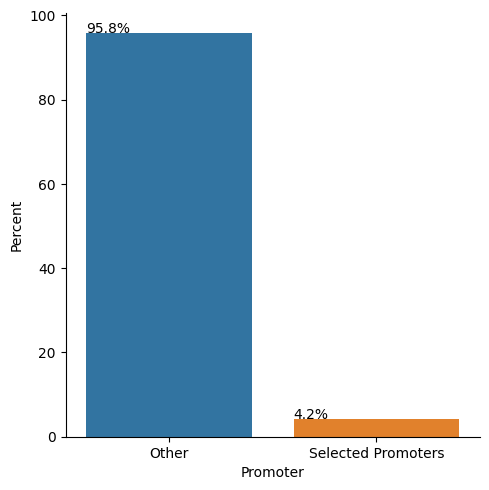

In [157]:
most_common_terms_promoter = [i[0] for i in fdist_actual_promoter.most_common(30)]

df_featurize_promoter['grouped_promoter']=df_featurize_promoter['promoter_transform'].apply(lambda x: 'Selected Promoters' if x in most_common_terms_promoter else 'Other')

promoter_categories_df = df_featurize_promoter['grouped_promoter'].value_counts(normalize=True)
promoter_categories_df = promoter_categories_df.mul(100).rename('Percent').reset_index()
promoter_categories_df.rename(columns = {'index':'Promoter'}, inplace = True)

g = sns.catplot(x='Promoter', y='Percent', kind='bar', data=promoter_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [270]:
df_featurize_promoter['promoter_transform'].describe()

count              1742197
unique              164542
top       LIVE NATION GMBH
freq                  5681
Name: promoter_transform, dtype: object

In [373]:
condition = df_featurize_promoter['promoter_clean']!='Other'

In [374]:
flat_list_clean_promoter = [item for item in df_featurize_promoter[condition]['promoter_clean']]
fdist_clean_promoter = FreqDist(flat_list_clean_promoter)
most_common_terms_clean_promoter = [i[0] for i in fdist_clean_promoter.most_common(30)] 


for term in most_common_terms_clean_promoter :
    df_featurize_promoter['promoter_'+term.lower()]=df_featurize_promoter['promoter_clean'].apply(lambda x: 1 if term in str(x) else 0)

display(df_featurize_promoter.head(5))

,PROMOTER,promoter_clean,promoter_live nation gmbh,promoter_fkp scorpio konzertproduktionen gmbh,promoter_trinity music gmbh,promoter_karsten jahnke konzertdirektion gmbh,promoter_prime entertainment gmbh,promoter_semmel concerts entertainment gmbh,promoter_chorverband nrw e.v,promoter_schwaebischer chorverband e.v,promoter_backstage concerts gmbh,promoter_kulturzentrum schlachthof wiesbaden e.v,promoter_irish pubs gaststaetten gmbh,promoter_fraenkischer saengerbund e.v,promoter_frankfurter kulturzentrum e.v,promoter_circus roncalli gmbh,promoter_paul daly und paul fleming gbr,promoter_foerderkreis jazz und malerei muenchen e.v,promoter_hessischer saengerbund e.v,promoter_gastro event gmbh,promoter_berninger musik & gastronomie gmbh,promoter_feierwerk e.v,promoter_bayerisches staatsbad bad steben gmbh,promoter_europa-park gmbh & co mack kg,promoter_badischer chorverband 1862 e.v,promoter_bayerisches wirtshaus berlin gmbh,promoter_tollwood gmbh,promoter_graeflicher park gmbh & co. kg,promoter_konzertbuero schoneberg gmbh,promoter_staatsbad salzuflen gmbh,promoter_kurverwaltung bad mergentheim gmbh,promoter_gisbert hiller
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,WIPPERDORFER CARNEVAL CLUB E.V 99752,WIPPERDORFER CARNEVAL CLUB E.V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,BAYERISCHE MOTORENWERKE AG 84130,BAYERISCHE MOTORENWERKE AG,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


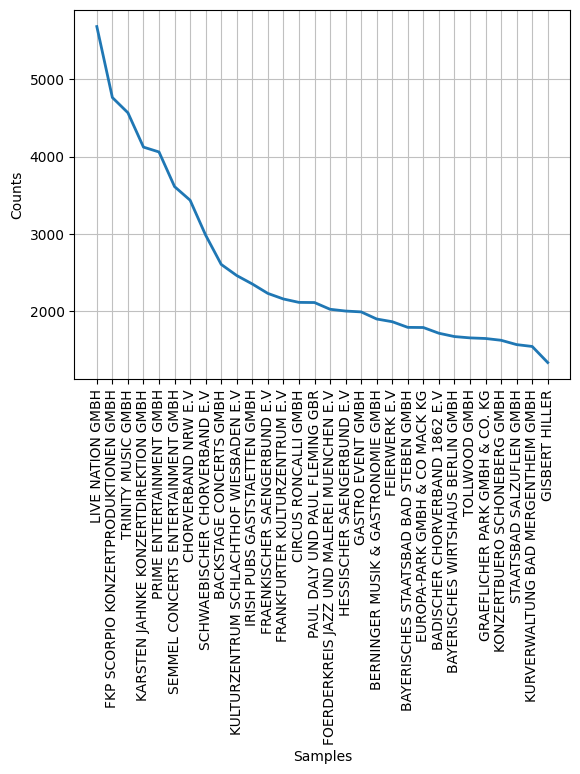

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [375]:
fdist_clean_promoter.plot(30,cumulative=False)

In [277]:
from collections import Counter

In [ ]:
# Clean promoter entries to remove repeating company type from each entry
def clean_promoters():
    promoters = ['CHORVERBAND NRW E.V', 'LIVE NATION GMBH', 'TRINITY MUSIC GMBH', 'KARSTEN JAHNKE KONZERTDIREKTION GMBH','FKP SCORPIO KONZERTPRODUKTIONEN GMBH',
    'PRIME ENTERTAINMENT GMBH', 'SEMMEL CONCERTS ENTERTAINMENT GMBH','FRAENKISCHER SAENGERBUND E.V', 'HESSISCHER SAENGERBUND E.V', 'BADISCHER CHORVERBAND 1862 E.V', 'IRISH PUBS GASTSTAETTEN GMBH', 
    'BACKSTAGE CONCERTS GMBH', 'PAUL DALY UND PAUL FLEMING GBR', 'FRANKFURTER KULTURZENTRUM E.V', 'KULTURZENTRUM SCHLACHTHOF WIESBADEN E.V', 'BAYERISCHES WIRTSHAUS BERLIN GMBH', 'BERNINGER MUSIK & GASTRONOMIE GMBH',
    'GRAEFLICHER PARK GMBH & CO. KG', 'CIRCUS RONCALLI GMBH', 'STAATSBAD SALZUFLEN GMBH', 'FOERDERKREIS JAZZ UND MALEREI MUENCHEN E.V', 'BACKSTAGE CONCERTS GMBH', 'CHAMAELEON THEATER GMBH', 
    'BERNINGER MUSIK & GASTRONOMIE GMBH', 'KURVERWALTUNG BAD MERGENTHEIM GMBH', 'SCHWAEBISCHER CHORVERBAND E.V', 'GASTRO EVENT GMBH', 
    'FEIERWERK E.V', 'TOLLWOOD GMBH', 'KONZERTBUERO SCHONEBERG GMBH', 'BAYERISCHES STAATSBAD BAD STEBEN GMBH']


    for each in promoters:
        condition = allclaims_df['VERANST_NAME'].str.contains(each,case=False)==True
        
        if each == 'SCHWAEBISCHER CHORVERBAND E.V':
            for item_index in df_featurize_promoter.index[condition]:
                if df_featurize_promoter.at[item_index, 'promoter_clean'] == 'SCHWAEBISCHER CHORVERBAND E.V':
                    df_featurize_promoter.at[item_index, 'promoter_clean'] = each
                elif df_featurize_promoter.at[item_index, 'promoter_clean'] == 'SCHWAEBISCHER CHORVERBAND E.V. E.V':
                    df_featurize_promoter.at[item_index, 'promoter_clean'] = each  
        elif each == 'GASTRO EVENT GMBH':
            for item_index in df_featurize_promoter.index[condition]:
                if df_featurize_promoter.at[item_index, 'promoter_clean'] ==  'GASTRO EVENT GMBH':
                    df_featurize_promoter.at[item_index, 'promoter_clean'] = each
                elif df_featurize_promoter.at[item_index, 'promoter_clean'] == 'GASTRO EVENT GMBH GMBH':
                    df_featurize_promoter.at[item_index, 'promoter_clean'] = each 
        else:
            df_featurize_promoter.loc[condition, 'promoter_clean'] = each

In [305]:
def cumulatively_categorise(column,threshold=0.75,return_categories_list=True):
  #Find the threshold value using the percentage and number of instances in the column
  threshold_value=int(threshold*len(column))
  #Initialise an empty list for our new minimised categories
  categories_list=[]
  #Initialise a variable to calculate the sum of frequencies
  s=0
  #Create a counter dictionary of the form unique_value: frequency
  counts=Counter(column)

  #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
  for i,j in counts.most_common():
    #Add the frequency to the global sum
    s+=dict(counts)[i]
    #Append the category name to the list
    categories_list.append(i)
    #Check if the global sum has reached the threshold value, if so break the loop
    if s>=threshold_value:
      break

  #Append the category Other to the list
  categories_list.append('Other')

  #Replace all instances not in our new categories by Other  
  new_column=column.apply(lambda x: x if x in categories_list else 'Other')

  #Return transformed column and unique values if return_categories=True
  if(return_categories_list):
    return new_column,categories_list
  #Return only the transformed column if return_categories=False
  else:
    return new_column

In [318]:
clean_promoters()
#Call the function with a default threshold of 75%
transformed_column,new_category_list=cumulatively_categorise(df_featurize_promoter['promoter_clean'],threshold=0.10,return_categories_list=True)

In [319]:
transformed_column.describe()

count     1742197
unique        169
top         Other
freq      1567726
Name: promoter_clean, dtype: object

In [320]:
new_category_list

['LIVE NATION GMBH',
 'FKP SCORPIO KONZERTPRODUKTIONEN GMBH',
 'TRINITY MUSIC GMBH',
 'KARSTEN JAHNKE KONZERTDIREKTION GMBH',
 'PRIME ENTERTAINMENT GMBH',
 'SEMMEL CONCERTS ENTERTAINMENT GMBH',
 'CHORVERBAND NRW E.V',
 'SCHWAEBISCHER CHORVERBAND E.V',
 'BACKSTAGE CONCERTS GMBH',
 'KULTURZENTRUM SCHLACHTHOF WIESBADEN E.V',
 'IRISH PUBS GASTSTAETTEN GMBH',
 'FRAENKISCHER SAENGERBUND E.V',
 'FRANKFURTER KULTURZENTRUM E.V',
 'CIRCUS RONCALLI GMBH',
 'PAUL DALY UND PAUL FLEMING GBR',
 'FOERDERKREIS JAZZ UND MALEREI MUENCHEN E.V',
 'HESSISCHER SAENGERBUND E.V',
 'GASTRO EVENT GMBH',
 'BERNINGER MUSIK & GASTRONOMIE GMBH',
 'FEIERWERK E.V',
 'BAYERISCHES STAATSBAD BAD STEBEN GMBH',
 'EUROPA-PARK GMBH & CO MACK KG',
 'BADISCHER CHORVERBAND 1862 E.V',
 'BAYERISCHES WIRTSHAUS BERLIN GMBH',
 'TOLLWOOD GMBH',
 'GRAEFLICHER PARK GMBH & CO. KG',
 'KONZERTBUERO SCHONEBERG GMBH',
 'STAATSBAD SALZUFLEN GMBH',
 'KURVERWALTUNG BAD MERGENTHEIM GMBH',
 'GISBERT HILLER',
 'CHAMAELEON THEATER GMBH',
 'THORSTE

In [ ]:
# Obtain all promoter names and the frequency of it's occurance
# for each in fdist_clean_promoter.items():
#     print(each)

### Extract company type from Promoter; promoter_company_type

In [172]:
company_types = ['E.V', 'GmbH', 'OHG', ' KG ', 'PartG', 'GMBH & CO. KG', 'GBR', ' AG ', 'KGAA', 'AG & CO. KG','GMBH & CO MACK KG','GMBH AG',
                'AG & CO. OHG','GMBH & CO KG',' UG ','K.D.OE.R','UG (HAFTUNGSBESCHRAENKT)','A.D.OE.R', ' EG ', ' STIFTUNG ', 'E.K', ' LTD ', ' mbH ']

In [173]:
df_featurize_promoter["promoter_company_type"] = np.nan

In [174]:
matching_company_type_indices = df_featurize_promoter.index[df_featurize_promoter['promoter_clean'].str.contains('|'.join(company_types),case=False)==True].tolist()
unmatching_company_type_indices = df_featurize_promoter.index[df_featurize_promoter['promoter_clean'].str.contains('|'.join(company_types),case=False)==False].tolist()

print(len(matching_company_type_indices))
print(len(unmatching_company_type_indices))

C:\Users\sgopalakrish\AppData\Local\Temp\ipykernel_8828\2994790444.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_company_type_indices = df_featurize_promoter.index[df_featurize_promoter['PROMOTER'].str.contains('|'.join(company_types),case=False)==True].tolist()
C:\Users\sgopalakrish\AppData\Local\Temp\ipykernel_8828\2994790444.py:2: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  unmatching_company_type_indices = df_featurize_promoter.index[df_featurize_promoter['PROMOTER'].str.contains('|'.join(company_types),case=False)==False].tolist()


1387115
355082


In [175]:
# Splitting into to n splits
matching_company_type_splits = np.array_split(matching_company_type_indices,304)
unmatching_company_type_splits = np.array_split(unmatching_company_type_indices,305)

for i in range(0,len(matching_company_type_splits)):
    slice_of_indices = matching_company_type_splits[i]

    for each_index in slice_of_indices:
        promoter = df_featurize_promoter.at[each_index, 'promoter_clean']
        res = [s for s in company_types if s.lower() in promoter.lower()]
        if 'GMBH & CO. KG' or 'GMBH & CO KG' in res:
            res = ['GMBH & CO. KG']
        if 'AG & CO. KG' in res:
            res = ['AG & CO. KG']    
        if 'E.V' in res:
            res = ['E.V'] 
        if 'GMBH AG' in res:
            res = ['GMBH']    
        if 'UG (HAFTUNGSBESCHRAENKT)' in res:
            res = ['UG (HAFTUNGSBESCHRAENKT)']    
        if len(res) > 1:
            print('The promoter {} and type is {}'.format(promoter,res))
        df_featurize_promoter.at[each_index, 'promoter_company_type'] = res[0].strip()
        
df_featurize_promoter["promoter_company_type"]

ID
9938766     GMBH & CO. KG
9939272     GMBH & CO. KG
9939279     GMBH & CO. KG
9939280     GMBH & CO. KG
9939281     GMBH & CO. KG
                ...      
13949320    GMBH & CO. KG
13949324              NaN
13949325    GMBH & CO. KG
13949328    GMBH & CO. KG
13949329    GMBH & CO. KG
Name: promoter_company_type, Length: 1742197, dtype: object

In [178]:
# Count NaN values for each 'promoter_company_type' in the dataframe
# 355082 - NaN values
# 387115 - Non empty values with different company types
display(df_featurize_promoter['promoter_company_type'].isna().sum())

355082

In [180]:
# Obtain promoters with NaN values
# for each in df_featurize_promoter[df_featurize_promoter['promoter_company_type'].isna()]['PROMOTER']:
#     print(each)

In [ ]:
# google maps API
# how big the city is?
# how close the location to the city centre?

## Venues

In [41]:
nlp = spacy.load('C:/Users/sgopalakrish/Miniconda3/Lib/site-packages/de_core_news_sm/de_core_news_sm-3.4.0/')
nlp_en = spacy.load('C:/Users/sgopalakrish/Miniconda3/Lib/site-packages/en_core_web_sm/en_core_web_sm-3.4.1')

In [42]:
german_stop_words = nlp.Defaults.stop_words
english_stop_words = nlp_en.Defaults.stop_words

In [43]:
def remove_special_chars_from(stopwords):
    cleaned_stop_words = []
    for each in stopwords:
        each = each.replace('ß','SS')
        each = each.upper()
        each = each.replace('Ä', 'AE')
        each = each.replace('Ö', 'OE')
        each = each.replace('Ü', 'UE')
        
        cleaned_stop_words.append(each)
    return cleaned_stop_words

In [44]:
cleaned_de_stopwords = remove_special_chars_from(german_stop_words)

additional_stopwords = [
    'ST', 'FREIEN', 'BAD', 'HAUS', 'EV', 'BERLIN', 'KATH', 'S', 'HOF', 'ALTE', 'MITTE', 'LUTH', 'MUENCHEN',
    'IRISH', 'MUSIK', 'KULTUR', 'FUER', 'EVANG', 'MARITIM', 'KOELN', 'U', 'TURN', 'E', 'STUTTGART', 'ALTES',
    'A', 'GASTES', 'THE', 'EUROPA', 'HANNOVER', 'STADT', 'BADEN', 'NUERNBERG', 'HAMBURG', 'NEUE',
    'EVANGELISCHE', 'LEIPZIG', 'B', 'DRESDEN', 'BREMEN', 'PETER', '1','ALTER', 'AM', 'DIE', 'DER',
    'DAS', 'DES', 'DEN', 'DEM', 'EIN', 'EINER', 'EINEM', 'EINES', 'EINE',
    'MEIN', 'MEINER', 'MEINES', 'MEINEM', 'MEINE', 'UND'
]


In [45]:
en_stop_words = []
for each in english_stop_words:
    en_stop_words.append(each)

In [46]:
all_stopwords = cleaned_de_stopwords + additional_stopwords + en_stop_words
all_stopwords = [x.lower() for x in all_stopwords]
# all_stopwords = list(map(lambda x: x.lower(), all_stopwords))

In [47]:
# Find all the categories of VG_RAUM
allclaims_df['VG_RAUM_clean']=allclaims_df['VG_RAUM'].astype(str).fillna('').map(lambda x: re.sub(r'\W+', ' ', x))

In [48]:
room_list_wo_stopwords = []
for each_room in allclaims_df['VG_RAUM_clean'].tolist():
    for each_stopword in all_stopwords:
        # Remove stopword from each row in VG_RAUM_clean 
        each_room.replace(each_stopword,'')
        
    if 'KIRCHE' in each_room:
        room_list_wo_stopwords.append('KIRCHE')
    else:
        room_list_wo_stopwords.append(each_room)

In [49]:
room_list_wo_stopwords = [x.lower() for x in room_list_wo_stopwords]

In [50]:
allclaims_df['VG_RAUM_WO_STOPWORDS'] = room_list_wo_stopwords

In [ ]:
# Stemming - removes suffixes and prefixes from word roots, 
# Lemmatization - maps the remaining root forms (which may not always be proper words) back to an actual word that occurs in natural language.

Get keywords using spacy

In [51]:
def get_keywords(text):
    result = []
    pos_tag = ['PROPN', 'NOUN', 'VERB']
    for token in text:
        if(token.text in all_stopwords or token.text in punctuation):
            continue
        if(token.pos_ in pos_tag):
            result.append(token.text) 
    return result

In [52]:
raum_cleaned_df = (row.VG_RAUM_WO_STOPWORDS for row in allclaims_df.itertuples())

vg_raum_keywords = []
for each_object in nlp.pipe(raum_cleaned_df):
  vg_raum_keywords.append(get_keywords(each_object))

In [53]:
allclaims_df['VG_RAUM_KEYWORDS'] = vg_raum_keywords

## Featurize VG_RAUM

In [135]:
flat_list_vg_raum_keywords = [item for sublist in allclaims_df['VG_RAUM_KEYWORDS'] for item in sublist]
fdist_vg_raum_keywords = FreqDist(flat_list_vg_raum_keywords)
most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(30)]

In [136]:
df_featurize_vg_raum_keywords = pd.DataFrame(allclaims_df['VG_RAUM_KEYWORDS'])

for term in most_common_terms_vg_raum :
    df_featurize_vg_raum_keywords['place_'+term]=df_featurize_vg_raum_keywords['VG_RAUM_KEYWORDS'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_vg_raum_keywords.head(10))

,VG_RAUM_KEYWORDS,place_kirche,place_hotel,place_cafe,place_theater,place_club,place_halle,place_gaststaette,place_festhalle,place_kulturzentrum,place_festzelt,place_schloss,place_pub,place_stadthalle,place_park,place_gasthof,place_kabarett,place_arena,place_schlachthof,place_wandelhalle,place_turnhalle,place_buergerhaus,place_museum,place_rathaus,place_staatsbad,place_zelt,place_jazz,place_forum,place_gymnasium,place_schule,place_sporthalle
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,"[turnhalle, sv, rw, lisberg]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
9939272,"[grundschule, wipperdorf]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,"[bmw, werk, dingolfing]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,[milbertshofen],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,[milbertshofen],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,"[gaststaette, gistl]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,[schuetzenheim],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,"[gaststaette, lustinger]",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,[martin],0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


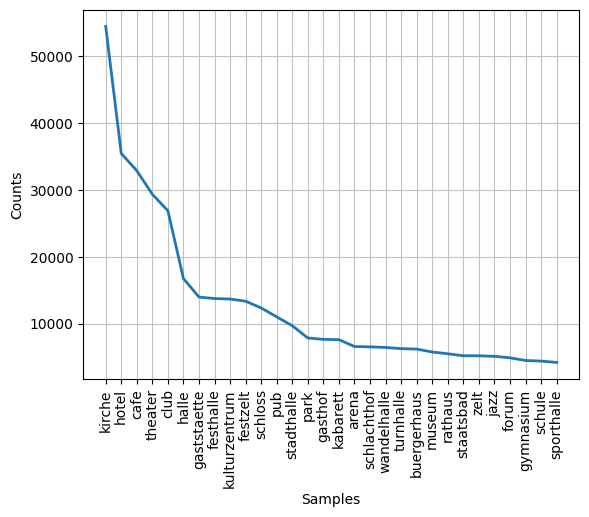

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [137]:
fdist_vg_raum_keywords.plot(30,cumulative=False)

### Group the frequent venues and rest of the venues to 'Other'

In [218]:
# most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(200)]

list_venue_wo_stopwords = [item for item in allclaims_df['VG_RAUM_WO_STOPWORDS']]
fdist_venue = FreqDist(list_venue_wo_stopwords)
most_common_terms_vg_raum = [i[0] for i in fdist_venue.most_common(2000)]

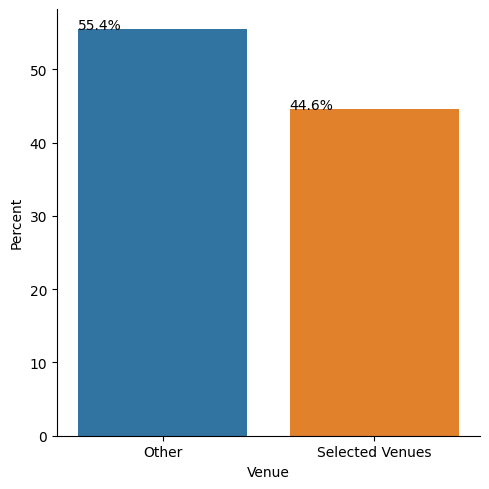

In [219]:
# for term in most_common_terms_vg_raum :
    # df_featurize_vg_raum_keywords['grouped_venue']=df_featurize_vg_raum_keywords['VG_RAUM_KEYWORDS'].apply(lambda x: 'Selected Venues' if term in x else 'Other')

df_featurize_vg_raum_keywords['grouped_venue']=allclaims_df['VG_RAUM_WO_STOPWORDS'].apply(lambda x: 'Selected Venues' if x in most_common_terms_vg_raum else 'Other') 


venue_categories_df = df_featurize_vg_raum_keywords['grouped_venue'].value_counts(normalize=True)
venue_categories_df = venue_categories_df.mul(100).rename('Percent').reset_index()
venue_categories_df.rename(columns = {'index':'Venue'}, inplace = True)

g = sns.catplot(x='Venue', y='Percent', kind='bar', data=venue_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [168]:
most_common_terms_vg_raum

['kirche',
 'hotel',
 'cafe',
 'theater',
 'club',
 'halle',
 'gaststaette',
 'festhalle',
 'kulturzentrum',
 'festzelt',
 'schloss',
 'pub',
 'stadthalle',
 'park',
 'gasthof',
 'kabarett',
 'arena',
 'schlachthof',
 'wandelhalle',
 'turnhalle',
 'buergerhaus',
 'museum',
 'rathaus',
 'staatsbad',
 'zelt',
 'jazz',
 'forum',
 'gymnasium',
 'schule',
 'sporthalle',
 'saal',
 'grundschule',
 'gemeindehalle',
 'werk',
 'music',
 'musikschule',
 'zentrum',
 'hall',
 'circus',
 'buergerzentrum',
 'live',
 'jazzclub',
 'bistro',
 'frankfurt',
 'gemeindehaus',
 'messe',
 'landgasthof',
 'kurhaus',
 'bahnhof',
 'fabrik',
 'galerie',
 'schuetzenhaus',
 'kurpark',
 'wuerzburg',
 'backstage',
 'burg',
 'wirtshaus',
 'sport',
 'freiburg',
 'center',
 'augsburg',
 'villa',
 'resort',
 'muenster',
 'kulturfabrik',
 'jugend',
 'sachs',
 'weingut',
 'dortmund',
 'buergersaal',
 'hirsch',
 'kantine',
 'welt',
 'grand',
 'mehrzweckhalle',
 'feierwerk',
 'brauhaus',
 'muehle',
 'keller',
 'kulturcafe',


In [201]:
len(fdist_vg_raum_keywords)
len(allclaims_df['VG_RAUM_KEYWORDS'])
allclaims_df['VG_RAUM_KEYWORDS']

# allclaims_df[allclaims_df['VG_RAUM_KEYWORDS'].str.len() == 0]['VG_RAUM_KEYWORDS']

ID
9938766     [turnhalle, sv, rw, lisberg]
9939272        [grundschule, wipperdorf]
9939279          [bmw, werk, dingolfing]
9939280                  [milbertshofen]
9939281                  [milbertshofen]
                        ...             
13949320                              []
13949324              [aula, hochschule]
13949325           [werk, kulturzentrum]
13949328                     [feierwerk]
13949329                              []
Name: VG_RAUM_KEYWORDS, Length: 1742197, dtype: object

In [205]:
allclaims_df['VG_RAUM_WO_STOPWORDS'].describe()

count     1742197
unique      87205
top        kirche
freq        54420
Name: VG_RAUM_WO_STOPWORDS, dtype: object

In [196]:
fdist_vg_raum_keywords.most_common(200)
# print(most_common_terms_vg_raum)
# most_common_terms_vg_raum = [i[0] for i in fdist_vg_raum_keywords.most_common(30)] 


[('kirche', 54420),
 ('hotel', 35430),
 ('cafe', 32846),
 ('theater', 29330),
 ('club', 26856),
 ('halle', 16736),
 ('gaststaette', 13954),
 ('festhalle', 13736),
 ('kulturzentrum', 13661),
 ('festzelt', 13335),
 ('schloss', 12325),
 ('pub', 10996),
 ('stadthalle', 9670),
 ('park', 7839),
 ('gasthof', 7634),
 ('kabarett', 7590),
 ('arena', 6563),
 ('schlachthof', 6511),
 ('wandelhalle', 6425),
 ('turnhalle', 6243),
 ('buergerhaus', 6179),
 ('museum', 5740),
 ('rathaus', 5480),
 ('staatsbad', 5183),
 ('zelt', 5175),
 ('jazz', 5099),
 ('forum', 4875),
 ('gymnasium', 4470),
 ('schule', 4385),
 ('sporthalle', 4185),
 ('saal', 4165),
 ('grundschule', 4164),
 ('gemeindehalle', 4119),
 ('werk', 4085),
 ('music', 4075),
 ('musikschule', 4068),
 ('zentrum', 3963),
 ('hall', 3844),
 ('circus', 3839),
 ('buergerzentrum', 3688),
 ('live', 3674),
 ('jazzclub', 3659),
 ('bistro', 3611),
 ('frankfurt', 3604),
 ('gemeindehaus', 3594),
 ('messe', 3588),
 ('landgasthof', 3586),
 ('kurhaus', 3580),
 ('ba

## Featurize BAND

In [142]:
flat_list_band = [item for item in allclaims_df['BAND']]
fdist_band_desc = FreqDist(flat_list_band)
most_common_terms_band = [i[0] for i in fdist_band_desc.most_common(30)] 
df_featurize_band = pd.DataFrame(allclaims_df['BAND'])

In [242]:
for term in most_common_terms_band :
    df_featurize_band['band_'+term.lower()]=df_featurize_band['BAND'].apply(lambda x: 1 if term in x else 0)

display(df_featurize_band.head(10))

,BAND,band_kurorchester bad wil,band_musikverein harmonie,band_kasalla,band_cat ballou,band_roncalli royal orch,band_jugendblasorchester,band_kurorchester bad pyr,band_hoehner,band_paveier,band_domstuermer,band_kluengelkoepp,band_alleinunterhalter,band_the gregorian voices,band_brings,band_musica hungarica,band_concerto,band_bad salzuflen orches,band_musikverein stadtkap,band_salonorchester hunga,band_miljoe,band_raeuber,band_kabarett leipziger f,band_marita koellner,band_salon-orchester hung,band_blaeck foeoess,band_schuelerinnen und sc,band_romain vicente,band_staatliche kurkapell,band_musikzug der freiwil,band_funky marys
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,DAS BOEHMISCHE FEUER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,KYFFHAEUSER TANZ BAN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939279,BERUFSFACHSCHULE,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939280,SIEBENBUERGER BLASMU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939281,SIEBENBUERGER BLASMU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939282,ZEPP-IN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939283,OVERCROWDED ELEVATOR,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939284,LMA,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939289,ALPENBAZIS,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


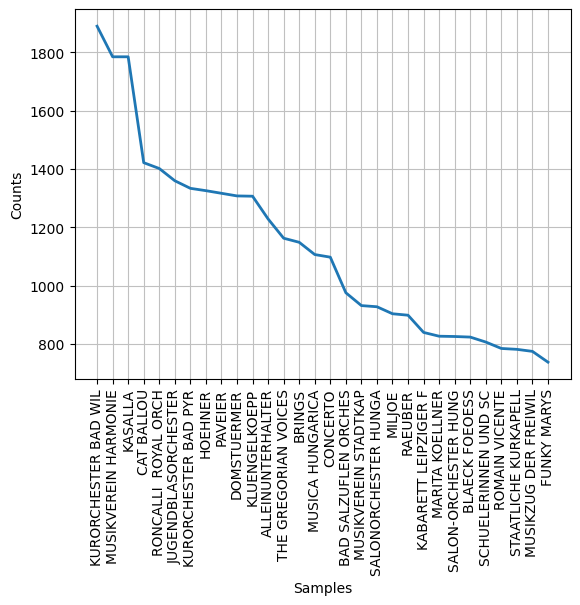

<AxesSubplot: xlabel='Samples', ylabel='Counts'>

In [243]:
fdist_band_desc.plot(30,cumulative=False)

### Group the frequent bands and rest of the bands to 'Other'

In [162]:
most_common_terms_band = [i[0] for i in fdist_band_desc.most_common(50)] 

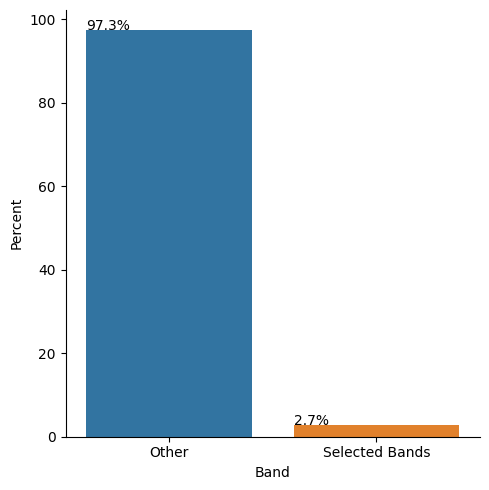

In [163]:
df_featurize_band['grouped_band']=allclaims_df['BAND'].apply(lambda x: 'Selected Bands' if x in most_common_terms_band else 'Other')

band_categories_df = df_featurize_band['grouped_band'].value_counts(normalize=True)
band_categories_df = band_categories_df.mul(100).rename('Percent').reset_index()
band_categories_df.rename(columns = {'index':'Band'}, inplace = True)

g = sns.catplot(x='Band', y='Percent', kind='bar', data=band_categories_df)

for p in g.ax.patches:
    txt = str(p.get_height().round(1)) + '%'
    txt_x = p.get_x()
    txt_y = p.get_height()
    g.ax.text(txt_x,txt_y,txt)

In [161]:
df_featurize_band['BAND'].describe()

count                  1742197
unique                  317007
top       KURORCHESTER BAD WIL
freq                      1890
Name: BAND, dtype: object

VERANST_SEGMENT

In [282]:
from sklearn.preprocessing import LabelEncoder

In [283]:
# Convert the VERANST_SEGMENT values from float to Int
allclaims_df.VERANST_SEGMENT = allclaims_df['VERANST_SEGMENT'].astype(int)

In [284]:
le = LabelEncoder()
allclaims_df['VERANST_SEGMENT'] = le.fit_transform(allclaims_df['VERANST_SEGMENT'])

VG_DATUM

In [285]:
allclaims_df['VG_DATUM_YEAR'] = le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.year)
allclaims_df['VG_DATUM_MONTH'] = le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.month)
allclaims_df['VG_DATUM_DAY_OF_WEEK']= le.fit_transform(allclaims_df['VG_DATUM_VON'].dt.dayofweek)

seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]
claim_season_list = [seasons[item] for item in allclaims_df['VG_DATUM_MONTH']]

allclaims_df['VG_DATUM_SEASON'] = claim_season_list

## Correlation Heatmap

### Define a new dataframe corr_df1, that contains only venue details

In [342]:
# Replace the list of keywords with most frequest keyword
def transform_venue(x, venue):
    venue_keywords = x

    if venue in venue_keywords:
        return venue
    else:
        return venue_keywords

In [301]:
corr_df1 = allclaims_df[['VG_RAUM_KEYWORDS']].copy()

In [334]:
venue_strs = []
for keyword_list in corr_df1['VG_RAUM_KEYWORDS'].values:
    if len(keyword_list) == 0:
        venue_strs.append('')
    else:
        ad = ' '.join(e for e in keyword_list)
        venue_strs.append(ad)

In [335]:
corr_df1['venue'] = venue_strs

In [347]:
# ['kirche', 'hotel', 'cafe', 'theater', 'club', 'halle', 'gaststaette', 'festhalle', 'kulturzentrum', 'festzelt', 
# 'schloss', 'pub', 'stadthalle', 'park', 'gasthof', 'kabarett', 'arena', 'schlachthof', 'wandelhalle', 'turnhalle', 
# 'buergerhaus', 'museum', 'rathaus', 'staatsbad', 'zelt', 'jazz', 'forum', 'gymnasium', 'schule', 'sporthalle']

corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue'], 'kirche'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'hotel'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'cafe'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'theater'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'club'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'halle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gaststaette'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'festhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'kulturzentrum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'festzelt'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schloss'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'pub'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'stadthalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'park'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gasthof'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'kabarett'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'arena'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schlachthof'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'wandelhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'turnhalle'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'buergerhaus'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'museum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'rathaus'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'staatsbad'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'zelt'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'jazz'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'forum'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'gymnasium'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'schule'), axis=1)
corr_df1['venue_clean'] = corr_df1.apply(lambda x: transform_venue(x['venue_clean'], 'sporthalle'), axis=1)

### Extract the selected features into a new dataframe corr_df, to visualize the correlation heatmap

In [380]:
feat_columns = ['VG_DATUM_YEAR','VG_DATUM_MONTH', 'VG_DATUM_DAY_OF_WEEK', 'VG_DATUM_SEASON', 'VERANST_SEGMENT', 
            'BAND', 'TARIF_BEZ', 'VG_RAUM_KEYWORDS', 'promoter_transform', 'vg_state']


corr_df = allclaims_df[feat_columns].copy()
corr_df['BAND'] = le.fit_transform(corr_df['BAND'])
corr_df['TARIF_BEZ'] = le.fit_transform(corr_df['TARIF_BEZ'])
corr_df['promoter_transform'] = le.fit_transform(corr_df['promoter_transform'])
corr_df['vg_state'] = le.fit_transform(corr_df['vg_state'])

corr_df['venue'] = corr_df1['venue_clean'].values 
corr_df['venue'] = le.fit_transform(corr_df['venue'])

feat_columns.append('venue')

In [382]:
corr_df=corr_df.rename(str.lower, axis='columns')

C:\Users\sgopalakrish\AppData\Local\Temp\ipykernel_35508\1029237510.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = corr_df[lower_feat_columns].corr()


<AxesSubplot: >

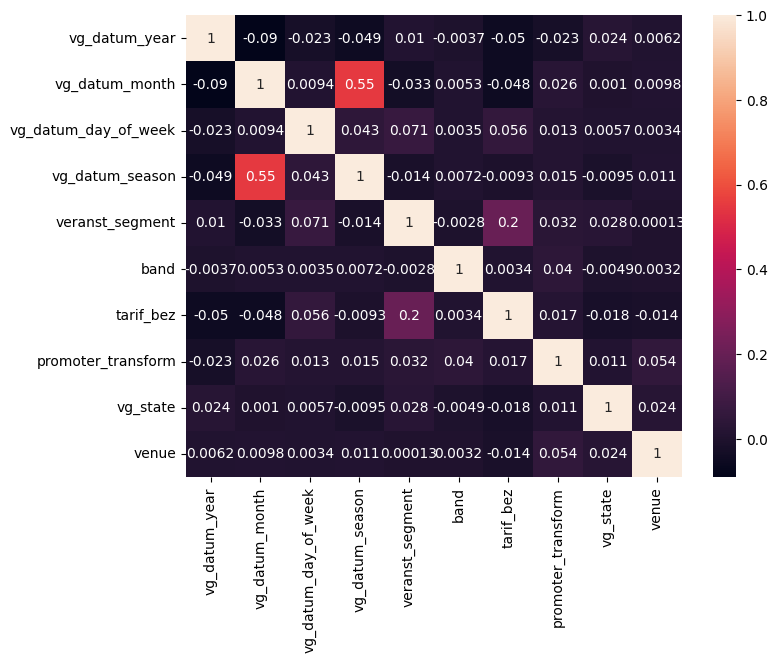

In [388]:
# Correlation between features
lower_feat_columns = [each.lower() for each in feat_columns]

corr = corr_df[lower_feat_columns].corr()
f, ax = plt.subplots(figsize=(8,6))

# Configure a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, annot=True)

## Merge all the features

In [273]:
allclaims_feature_df = allclaims_df.merge(df_featurize_vg_raum_keywords, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_tarif, how='left', on='ID')
# allclaims_feature_df = allclaims_feature_df.merge(df_featurize_vg_ort, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_vg_state, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_band, how='left', on='ID')
allclaims_feature_df = allclaims_feature_df.merge(df_featurize_promoter, how='left', on='ID')

In [379]:
drop_columns = ['promoter_y', 
'promoter_clean', 
'promoter_live nation gmbh',
'promoter_fkp scorpio konzertproduktionen gmbh', 
'promoter_trinity music gmbh', 
'promoter_karsten jahnke konzertdirektion gmbh', 
'promoter_prime entertainment gmbh', 
'promoter_semmel concerts entertainment gmbh', 
'promoter_chorverband nrw e.v', 
'promoter_schwaebischer chorverband e.v', 
'promoter_backstage concerts gmbh', 
'promoter_kulturzentrum schlachthof wiesbaden e.v', 
'promoter_irish pubs gaststaetten gmbh', 
'promoter_fraenkischer saengerbund e.v', 
'promoter_frankfurter kulturzentrum e.v', 
'promoter_circus roncalli gmbh', 
'promoter_paul daly und paul fleming gbr', 
'promoter_foerderkreis jazz und malerei muenchen e.v', 
'promoter_hessischer saengerbund e.v', 
'promoter_gastro event gmbh', 
'promoter_berninger musik & gastronomie gmbh',  
'promoter_europa-park gmbh & co mack kg', 
'promoter_badischer chorverband 1862 e.v', 
'promoter_bayerisches wirtshaus berlin gmbh', 
'promoter_graeflicher park gmbh & co. kg',
'promoter_staatsbad salzuflen gmbh', 
'promoter_kurverwaltung bad mergentheim gmbh', 
'promoter_gisbert hiller',
'promoter_chamaeleon theater gmbh',
'promoter_thorsten wolf',
'promoter_thomas vogler', 
'promoter_bad woerishofen k.d.oe.r. kur- und tourismusbetrieb k. d. oe. r']

allclaims_feature_df.drop(drop_columns, axis=1, inplace=True)

In [381]:
display(allclaims_df.head(5))

,IMP_ID,GJ,IMPORT,MUFO_REFERENZ_N,BARCODE_NR,VERANST_SEGMENT,REKLA_JN,VG_DATUM_VON,VG_ORT,VG_RAUM,NUTZFALL,NUTZFALL_RAUM,MUSIKLEITER_NAME,KAPELLE_NAME,TARIF_NR,TARIF_BEZ,NUTZFALL_NR,VG_INKASSO,INKASSO_NETTO,INKASSO_BRUTTO,VERANST_GESCHAEFTSZEICHEN,VERANST_NAME,VERANST_STRASSE,VERANST_PLZ,VERANST_ORT,NUTZLIZNEHM_GESCHAEFTSZEICHEN,NUTZLIZNEHM_NAME,NUTZLIZNEHM_VORNAME,NUTZLIZNEHM_STRASSE,NUTZLIZNEHM_PLZ,NUTZLIZNEHM_ORT,LOCATION,BAND,PROMOTER,vg_state,VG_RAUM_clean,VG_RAUM_WO_STOPWORDS,VG_RAUM_KEYWORDS,VG_DATUM_YEAR,VG_DATUM_MONTH,VG_DATUM_DAY_OF_WEEK,VG_DATUM_SEASON
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,2,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.00,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,80084,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,BAVARIA,TURNHALLE SV RW LISBERG,turnhalle sv rw lisberg,"[turnhalle, sv, rw, lisberg]",0,1,5,0
9939272,24643,2016,ABRE U INKA 2016,NaN,5053180236,1,NONRekla,2014-02-22,WIPPERDORF,STAATLICHE GRUNDSCHULE WIPPERDORF,20140222.0,STAATLICHE GRUNDSCHULE WIPPERDORF,PATSCHKE RAINER,KYFFHAEUSER TANZ BAN,1087,U-V II. 1 (+II 2),17923031,85.06,NaN,NaN,1374109400,WIPPERDORFER CARNEVAL CLUB E.V,STRASSE DER EINHEIT 6,99752,WIPPERDORF,1374109400,WIPPERDORFER CARNEVAL CLUB,NaN,STRASSE DER EINHEIT 6,99752,WIPPERDORF,WIPPERDORF STAATLICHE GRUNDSCHULE WIPPERDORF,KYFFHAEUSER TANZ BAN,WIPPERDORFER CARNEVAL CLUB E.V 99752,THURINGIA,STAATLICHE GRUNDSCHULE WIPPERDORF,staatliche grundschule wipperdorf,"[grundschule, wipperdorf]",0,1,5,0
9939279,24643,2016,ABRE U INKA 2016,NaN,5053345001,1,NONRekla,2014-02-18,DINGOLFING,BMW-WERK DINGOLFING,20140218.0,BMW-WERK DINGOLFING,JUNDMAYER,BERUFSFACHSCHULE,1087,U-V II. 1 (+II 2),17757433,90.20,NaN,NaN,2000026695,BAYERISCHE MOTORENWERKE AG,MENGKOFENER STR. 13,84130,DINGOLFING,2000026695,BAYERISCHE MOTORENWERKE,NaN,MENGKOFENER STR. 13,84130,DINGOLFING,DINGOLFING BMW-WERK DINGOLFING,BERUFSFACHSCHULE,BAYERISCHE MOTORENWERKE AG 84130,BAVARIA,BMW WERK DINGOLFING,bmw werk dingolfing,"[bmw, werk, dingolfing]",0,1,1,0
9939280,24643,2016,ABRE U INKA 2016,NaN,5053345402,2,NONRekla,2014-03-29,MUENCHEN,KULTURHAUS MILBERTSHOFEN,20140329.0,KULTURHAUS MILBERTSHOFEN,SCHULLERUS WERNER,SIEBENBUERGER BLASMU,1087,U-V II. 1 (+II 2),18051337,206.12,NaN,NaN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,KORNWEGERSTR. 10,81375,MUENCHEN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD,NaN,KORNWEGERSTR. 10,81375,MUENCHEN,MUENCHEN KULTURHAUS MILBERTSHOFEN,SIEBENBUERGER BLASMU,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,BAVARIA,KULTURHAUS MILBERTSHOFEN,kulturhaus milbertshofen,[milbertshofen],0,2,5,1
9939281,24643,2016,ABRE U INKA 2016,NaN,5053345418,2,NONRekla,2014-03-21,MUENCHEN,KULTURHAUS MILBERTSHOFEN,20140321.0,KULTURHAUS MILBERTSHOFEN,SCHULLERUS WERNER,SIEBENBUERGER BLASMU,1087,U-V II. 1 (+II 2),18051299,206.12,NaN,NaN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V,KORNWEGERSTR. 10,81375,MUENCHEN,910166400,MAENNERCHOR MILBERTSHOFEN-RIESENFELD,NaN,KORNWEGERSTR. 10,81375,MUENCHEN,MUENCHEN KULTURHAUS MILBERTSHOFEN,SIEBENBUERGER BLASMU,MAENNERCHOR MILBERTSHOFEN-RIESENFELD E.V 81375,BAVARIA,KULTURHAUS MILBERTSHOFEN,kulturhaus milbertshofen,[milbertshofen],0,2,4,1


In [380]:
display(allclaims_feature_df.head(5))

,imp_id,gj,import,mufo_referenz_n,barcode_nr,veranst_segment,rekla_jn,vg_datum_von,vg_ort,vg_raum,nutzfall,nutzfall_raum,musikleiter_name,kapelle_name,tarif_nr,tarif_bez_x,nutzfall_nr,vg_inkasso,inkasso_netto,inkasso_brutto,veranst_geschaeftszeichen,veranst_name,veranst_strasse,veranst_plz,veranst_ort,nutzliznehm_geschaeftszeichen,nutzliznehm_name,nutzliznehm_vorname,nutzliznehm_strasse,nutzliznehm_ort,location,band_x,promoter_x,vg_state_x,vg_raum_clean,vg_raum_wo_stopwords,vg_raum_keywords_x,vg_datum_year,vg_datum_month,vg_datum_day_of_week,vg_datum_season,vg_raum_keywords_y,place_kirche,place_hotel,place_cafe,place_theater,place_club,place_halle,place_gaststaette,place_festhalle,place_kulturzentrum,place_festzelt,place_schloss,place_pub,place_stadthalle,place_park,place_gasthof,place_kabarett,place_arena,place_schlachthof,place_wandelhalle,place_turnhalle,place_buergerhaus,place_museum,place_rathaus,place_staatsbad,place_zelt,place_jazz,place_forum,place_gymnasium,place_schule,place_sporthalle,tarif_bez_y,tarif_u-v ii. 1 (+ii 2),tarif_u-k (musiker),tarif_u-k (musiker) mindestverguetung,tarif_u-st i. (musiker),tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil,tarif_u-st i (musiker) nl,tarif_u-v iii. 1,tarif_u-v iii. 2,tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten,tarif_variete i (musiker),tarif_u-v vi. b,tarif_e (musiker),tarif_p-k i. (u-musik),tarif_u-k ii. (musiker) bis 50 min,tarif_u-k ii. (musiker) bis 20 min,tarif_e-p,tarif_u-k ii. (musiker) bis 25 min,tarif_u-k ii. (musiker) bis 15 min,tarif_u-k ii. (musiker) bis 30 min,tarif_u-k ii. (musiker) bis 10 min,tarif_u-st (musiker),tarif_chorverband konzert u-musik,tarif_vk i 3 zirkusunternehmen (musiker),tarif_u-k ii. (musiker) bis 5 min,tarif_u-k ii. (musiker) bis 35 min,tarif_u-k ii. (musiker) bis 40 min,tarif_p-k i. (e-musik),tarif_u-k ii (musiker) mindestverguetung,tarif_u-k ii. (musiker) bis 45 min,tarif_u-v vi. b mindestverguetung,vg_state_y,state_bavaria,state_thuringia,state_baden-wuerttemberg,state_rhineland-palatinate,state_brandenburg,state_berlin,state_lower saxony,state_schleswig-holstein,state_hamburg,state_hesse,state_saarland,state_north rhine-westphalia,state_saxony-anhalt,state_saxony,state_mecklenburg-western pomerania,state_bremen,band_y,band_kurorchester bad wil,band_musikverein harmonie,band_kasalla,band_cat ballou,band_roncalli royal orch,band_jugendblasorchester,band_kurorchester bad pyr,band_hoehner,band_paveier,band_domstuermer,band_kluengelkoepp,band_alleinunterhalter,band_the gregorian voices,band_brings,band_musica hungarica,band_concerto,band_bad salzuflen orches,band_musikverein stadtkap,band_salonorchester hunga,band_miljoe,band_raeuber,band_kabarett leipziger f,band_marita koellner,band_salon-orchester hung,band_blaeck foeoess,band_schuelerinnen und sc,band_romain vicente,band_staatliche kurkapell,band_musikzug der freiwil,band_funky marys
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
9938766,24643,2016,ABRE U INKA 2016,NaN,5027961235,2,NONRekla,2014-02-08,LISBERG,TURNHALLE SV RW LISBERG,20140208.0,TURNHALLE SV RW LISBERG,STAERK REINHOLD,DAS BOEHMISCHE FEUER,892,U-K (MUSIKER),18293091,210.00,NaN,NaN,1035530900,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V,SCHINDHOLZWEG 17,96194,WALSDORF,1510423300,BAYERISCHER BLASMUSIKVERBAND,NaN,NaN,MUENCHEN,LISBERG TURNHALLE SV RW LISBERG,DAS BOEHMISCHE FEUER,AURACHTALER BLASMUSIKVEREIN WALSDORF E.V 96194,BAVARIA,TURNHALLE SV RW LISBERG,turnhalle sv rw lisberg,"[turnhalle, sv, rw, lisberg]",0,1,5,0,"[turnhalle, sv, rw, lisberg]",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,U-K (MUSIKER),0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,BAVARIA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,DAS BOEHMISCHE FEUER,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9939272,24643,2016,ABRE U INKA 2016,NaN,5053180236,1,NONRekla,2014-02-22,WIPPERDORF,STAATLICHE GRUNDSCHULE WIPPERDOR

In [274]:
allclaims_feature_df=allclaims_feature_df.rename(str.lower, axis='columns')

In [ ]:
#allclaims_feature_df.to_pickle('./data/export_features_2016_2020_v1.pkl.bz2', protocol=4)

In [275]:
# ArrowTypeError: ("Expected bytes, got a 'float' object", 'Conversion failed for column nutzliznehm_plz with type object')
allclaims_feature_df = allclaims_feature_df.drop('nutzliznehm_plz', axis=1)

In [50]:
# allclaims_feature_df.to_parquet('./data/export_features_2016_2020_v2.parquet.gzip',compression='gzip')

In [276]:
allclaims_feature_df.to_parquet('./data/export_features_2016_2020_v3.parquet.gzip',compression='gzip')

In [ ]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'VG_ORT', 'TARIF_BEZ'
features = ['tarif_u-v ii. 1 (+ii 2)', 'tarif_u-k (musiker)', 
'tarif_u-k (musiker) mindestverguetung','tarif_u-st i. (musiker)', 
'tarif_e-p', 'tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil', 
'tarif_u-v iii. 1', 'tarif_u-st i (musiker) nl', 'tarif_u-v iii. 2', 
'tarif_e (musiker)', 'tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten', 
'tarif_p-k i. (u-musik)', 'tarif_chorverband konzert u-musik', 
'tarif_u-v vi. b','tarif_variete i (musiker)',
'tarif_u-k ii. (musiker) bis 20 min','tarif_u-k ii. (musiker) bis 25 min',
'tarif_u-k ii. (musiker) bis 15 min','tarif_u-k ii. (musiker) bis 50 min',
'tarif_u-k ii. (musiker) bis 30 min','tarif_u-k ii. (musiker) bis 10 min',
'tarif_vk i 3 zirkusunternehmen (musiker)','tarif_p-k i. (e-musik)',
'tarif_u-st (musiker)','tarif_u-k ii. (musiker) bis 5 min',
'tarif_u-k ii. (musiker) bis 35 min','tarif_u-k ii. (musiker) bis 40 min',
'tarif_u-v-ks (musiker)','tarif_u-k ii (musiker) mindestverguetung',
'tarif_u-k ii. (musiker) bis 45 min',

'place_kirche','place_hotel','place_stadthalle','place_club',
'place_buergerhaus','place_theater','place_halle','place_festhalle',
'place_kurhaus','place_schloss','place_cafe','place_kulturzentrum',
'place_festzelt','place_musikschule','place_mehrzweckhalle','place_pub',
'place_bar','place_turnhalle','place_gasthaus','place_gymnasium',
'place_rathaus','place_park','place_gasthof','place_kabarett',
'place_schuetzenhalle','place_gemeindehalle','place_gaststaette',
'place_schule','place_museum','place_vereinsheim',

# 'location_berlin','location_muenchen','location_hamburg','location_koeln',
# 'location_stuttgart','location_leipzig','location_frankfurt am main',
# 'location_dresden','location_hannover','location_nuernberg','location_duesseldorf',
# 'location_bremen','location_karlsruhe','location_dortmund','location_essen',
# 'location_augsburg','location_mannheim','location_muenster','location_bonn',
# 'location_wiesbaden','location_erfurt','location_kiel','location_regensburg',
# 'location_freiburg im breisgau','location_chemnitz','location_mainz',
# 'location_wuerzburg','location_magdeburg','location_potsdam',
# 'location_bielefeld',

'state_bavaria','state_rhineland-palatinate',
'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
'state_thuringia','state_hesse',	
'state_brandenburg', 'state_schleswig-holstein',	
'state_berlin',	'state_mecklenburg-western pomerania',	
'state_lower saxony', 'state_hamburg',	
'state_saarland', 'state_saxony-anhalt',	
'state_saxony',	'state_bremen',

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season'
]

In [ ]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'vg_state', 'BAND'
features_v1 = ['place_kirche', 'place_hotel', 'place_cafe',
 'place_theater', 'place_club', 'place_halle',
 'place_gaststaette', 'place_festhalle', 'place_kulturzentrum',
 'place_festzelt', 'place_schloss', 'place_pub',
 'place_stadthalle', 'place_park', 'place_gasthof',
 'place_kabarett', 'place_arena', 'place_schlachthof',
 'place_wandelhalle', 'place_turnhalle', 'place_buergerhaus',
 'place_museum', 'place_rathaus', 'place_staatsbad',
 'place_zelt', 'place_jazz', 'place_forum',
 'place_gymnasium', 'place_schule', 'place_sporthalle', 

'band_kurorchester bad wil', 'band_musikverein harmonie', 'band_kasalla',
 'band_cat ballou', 'band_roncalli  royal orch', 'band_jugendblasorchester',
 'band_kurorchester bad pyr', 'band_hoehner', 'band_paveier',
 'band_domstuermer', 'band_kluengelkoepp', 'band_alleinunterhalter',
 'band_the gregorian voices', 'band_brings', 'band_musica hungarica',
 'band_concerto', 'band_bad salzuflen orches', 'band_musikverein stadtkap',
 'band_salonorchester hunga', 'band_miljoe', 'band_raeuber',
 'band_kabarett leipziger f', 'band_marita koellner', 'band_salon-orchester hung',
 'band_blaeck foeoess', 'band_schuelerinnen und sc', 'band_romain vicente',
 'band_staatliche kurkapell', 'band_musikzug der freiwil', 'band_funky marys',

'state_bavaria','state_rhineland-palatinate',
'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
'state_thuringia','state_hesse',	
'state_brandenburg', 'state_schleswig-holstein',	
'state_berlin',	'state_mecklenburg-western pomerania',	
'state_lower saxony', 'state_hamburg',	
'state_saarland', 'state_saxony-anhalt',	
'state_saxony',	'state_bremen',

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season']

In [ ]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'vg_state', 'BAND', 'PROMOTER'
features_v2 = ['place_kirche', 'place_hotel', 'place_cafe',
 'place_theater', 'place_club', 'place_halle',
 'place_gaststaette', 'place_festhalle', 'place_kulturzentrum',
 'place_festzelt', 'place_schloss', 'place_pub',
 'place_stadthalle', 'place_park', 'place_gasthof',
 'place_kabarett', 'place_arena', 'place_schlachthof',
 'place_wandelhalle', 'place_turnhalle', 'place_buergerhaus',
 'place_museum', 'place_rathaus', 'place_staatsbad',
 'place_zelt', 'place_jazz', 'place_forum',
 'place_gymnasium', 'place_schule', 'place_sporthalle',

 'band_kurorchester bad wil', 'band_musikverein harmonie', 'band_kasalla',
 'band_cat ballou', 'band_roncalli  royal orch', 'band_jugendblasorchester',
 'band_kurorchester bad pyr', 'band_hoehner', 'band_paveier',
 'band_domstuermer', 'band_kluengelkoepp', 'band_alleinunterhalter',
 'band_the gregorian voices', 'band_brings', 'band_musica hungarica',
 'band_concerto', 'band_bad salzuflen orches', 'band_musikverein stadtkap',
 'band_salonorchester hunga', 'band_miljoe', 'band_raeuber',
 'band_kabarett leipziger f', 'band_marita koellner', 'band_salon-orchester hung',
 'band_blaeck foeoess', 'band_schuelerinnen und sc', 'band_romain vicente',
 'band_staatliche kurkapell', 'band_musikzug der freiwil', 'band_funky marys',


'state_bavaria','state_rhineland-palatinate',
'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
'state_thuringia','state_hesse',	
'state_brandenburg', 'state_schleswig-holstein',	
'state_berlin',	'state_mecklenburg-western pomerania',	
'state_lower saxony', 'state_hamburg',	
'state_saarland', 'state_saxony-anhalt',	
'state_saxony',	'state_bremen',

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season']

In [ ]:
# Feautes used - 'VG_RAUM_KEYWORDS', 'VG_DATUM_VON', 'vg_state', 'BAND', 'PROMOTER', TARIF_BEZ
features_v3 = ['place_kirche', 'place_hotel', 'place_cafe',
 'place_theater', 'place_club', 'place_halle',
 'place_gaststaette', 'place_festhalle', 'place_kulturzentrum',
 'place_festzelt', 'place_schloss', 'place_pub',
 'place_stadthalle', 'place_park', 'place_gasthof',
 'place_kabarett', 'place_arena', 'place_schlachthof',
 'place_wandelhalle', 'place_turnhalle', 'place_buergerhaus',
 'place_museum', 'place_rathaus', 'place_staatsbad',
 'place_zelt', 'place_jazz', 'place_forum',
 'place_gymnasium', 'place_schule', 'place_sporthalle',

'tarif_u-v ii. 1 (+ii 2)', 'tarif_u-k (musiker)', 'tarif_u-k (musiker) mindestverguetung', 
'tarif_u-k i (+ ii 2b) - mit sonstigem geldwerten vorteil', 'tarif_u-st i (musiker) nl', 'tarif_u-v iii. 1', 
'tarif_u-v iii. 2', 'tarif_u-k iii. 2d) (musiker) - vor geladenen gaesten', 'tarif_variete i (musiker)', 
'tarif_u-v vi. b', 'tarif_e (musiker)', 'tarif_p-k i. (u-musik)', 
'tarif_u-k ii. (musiker) bis 50 min', 'tarif_u-k ii. (musiker) bis 20 min', 'tarif_e-p', 
'tarif_u-k ii. (musiker) bis 15 min', 'tarif_u-k ii. (musiker) bis 25 min', 'tarif_u-k ii. (musiker) bis 30 min', 
'tarif_u-st (musiker)', 'tarif_u-k ii. (musiker) bis 10 min', 'tarif_chorverband konzert u-musik',
'tarif_vk i 3 zirkusunternehmen (musiker)', 'tarif_u-k ii. (musiker) bis 5 min', 'tarif_u-k ii. (musiker) bis 35 min', 
'tarif_u-k ii. (musiker) bis 40 min', 'tarif_p-k i. (e-musik)', 'tarif_u-st i. (musiker)', 
'tarif_u-k ii (musiker) mindestverguetung', 'tarif_u-k ii. (musiker) bis 45 min', 'tarif_u-v vi. b mindestverguetung', 


'band_kurorchester bad wil', 'band_musikverein harmonie', 'band_kasalla',
 'band_cat ballou', 'band_roncalli  royal orch', 'band_jugendblasorchester',
 'band_kurorchester bad pyr', 'band_hoehner', 'band_paveier',
 'band_domstuermer', 'band_kluengelkoepp', 'band_alleinunterhalter',
 'band_the gregorian voices', 'band_brings', 'band_musica hungarica',
 'band_concerto', 'band_bad salzuflen orches', 'band_musikverein stadtkap',
 'band_salonorchester hunga', 'band_miljoe', 'band_raeuber',
 'band_kabarett leipziger f', 'band_marita koellner', 'band_salon-orchester hung',
 'band_blaeck foeoess', 'band_schuelerinnen und sc', 'band_romain vicente',
 'band_staatliche kurkapell', 'band_musikzug der freiwil', 'band_funky marys',


'state_bavaria','state_rhineland-palatinate',
'state_baden-wuerttemberg',	'state_north rhine-westphalia',	
'state_thuringia','state_hesse',	
'state_brandenburg', 'state_schleswig-holstein',	
'state_berlin',	'state_mecklenburg-western pomerania',	
'state_lower saxony', 'state_hamburg',	
'state_saarland', 'state_saxony-anhalt',	
'state_saxony',	'state_bremen',

'vg_datum_year','vg_datum_month','vg_datum_day_of_week','vg_datum_season',

'promoter_live nation gmbh',
'promoter_fkp scorpio konzertproduktionen gmbh', 
'promoter_trinity music gmbh', 
'promoter_karsten jahnke konzertdirektion gmbh', 
'promoter_prime entertainment gmbh', 
'promoter_semmel concerts entertainment gmbh', 
'promoter_chorverband nrw e.v', 
'promoter_schwaebischer chorverband e.v', 
'promoter_backstage concerts gmbh', 
'promoter_kulturzentrum schlachthof wiesbaden e.v', 
'promoter_irish pubs gaststaetten gmbh', 
'promoter_fraenkischer saengerbund e.v', 
'promoter_frankfurter kulturzentrum e.v', 
'promoter_circus roncalli gmbh', 
'promoter_paul daly und paul fleming gbr', 
'promoter_foerderkreis jazz und malerei muenchen e.v', 
'promoter_hessischer saengerbund e.v', 
'promoter_gastro event gmbh', 
'promoter_berninger musik & gastronomie gmbh', 
'promoter_feierwerk e.v',
'promoter_bayerisches staatsbad bad steben gmbh', 
'promoter_europa-park gmbh & co mack kg', 
'promoter_badischer chorverband 1862 e.v', 
'promoter_bayerisches wirtshaus berlin gmbh', 
'promoter_tollwood gmbh', 
'promoter_graeflicher park gmbh & co. kg',
'promoter_konzertbuero schoneberg gmbh',  	
'promoter_staatsbad salzuflen gmbh', 
'promoter_kurverwaltung bad mergentheim gmbh', 
'promoter_gisbert hiller' 

# 'promoter_chamaeleon theater gmbh',
# 'promoter_thorsten wolf',
# 'promoter_thomas vogler', 
# 'promoter_bad woerishofen k.d.oe.r. kur- und tourismusbetrieb k. d. oe. r'

]

Baseline Classifier models to classify event segments

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
X = allclaims_feature_df[features]
y = allclaims_feature_df['veranst_segment']

In [ ]:
print(allclaims_df['VG_RAUM_KEYWORDS'].dtypes)
print(allclaims_df['VG_DATUM_VON'].dtypes)
print(allclaims_df['VG_ORT'].dtypes)
print(allclaims_df['TARIF_BEZ'].dtypes)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

XGBoost Classifier

In [ ]:
pip install xgboost

In [ ]:
import xgboost

xgboost_classifier = xgboost.XGBClassifier()
xgboost_classifier.fit(X_train, y_train)

In [ ]:
# save the model to disk
xbg_filename = 'xgb_classifier_model.sav'
pickle.dump(xgboost_classifier, open(xbg_filename, 'wb'))

In [ ]:
y_pred = xgboost_classifier.predict(X_test)

Evaluation

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

xgboost_accuracy = accuracy_score(y_test, y_pred, normalize=False)
print(xgboost_accuracy)

SVC Classifier

In [ ]:
svclassifier = SVC(kernel='linear')
svclassifier.fit(X_train, y_train)

In [ ]:
# save the model to disk
filename = 'svc_classifier_model.sav'
pickle.dump(svclassifier, open(filename, 'wb'))

In [ ]:
y_pred = svclassifier.predict(X_test)

Evaluation

In [ ]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

svc_accuracy = accuracy_score(y_test, y_pred, normalize=False)
print(svc_accuracy)

In [ ]:
# Group the places by the state
# Find the missing places using the PLZ or using the VG_Raum

In [ ]:
# There are only 2 values in the INKASSO_NETTO and INKASSO_BRUTTO
# There are no null values in VG_INKASSO
# Lowest value of VG_INKASSO is 0.04 and highest value is 409.7
# How could segment 2 (0 - 50 euros) and segment 3 (50-100 euros) would have high VG_INKASSO values?
